In [1]:
## Parameters

dataset_url = 'https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz'
dest = ''
use_google_drive = False
saving_path = dest + 'Bootcamp/Model/'
aug_saving_path = dest + 'Bootcamp/Data/'

target_size = (224, 224)
batch_size = 32

## Making Directories

!mkdir 'Bootcamp/'
!mkdir 'Bootcamp/Model/'
!mkdir 'Bootcamp/Data/'

### Importing Data and Packages


In [2]:
!pip install gdown
!pip install imblearn
!pip install opencv-python

     |████████████████████████████████| 78 kB 451 kB/s eta 0:00:01
     |████████████████████████████████| 257 kB 384 kB/s eta 0:00:01
     |████████████████████████████████| 62.2 MB 836 kB/s eta 0:00:011


#### Packages

In [3]:
## Required Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gdown
import zipfile

import os
import cv2

from PIL import Image

from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Input, concatenate
from keras.utils import to_categorical
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import GlorotNormal, HeNormal
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.applications import InceptionV3, MobileNet, Xception, VGG16, InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from sklearn.metrics import confusion_matrix, f1_score

2024-04-12 10:01:52.715415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 10:01:53.584834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Functions

In [4]:
def read_img(dataset, shape_info = False):

    data = []
    for index, row in dataset.iterrows():

        image = cv2.imread(row['dest'])

        try:
            if shape_info:
                height, width, channels = image.shape
                data.append({'name': row['name'], 'height': height, 'width': width, 'channels': channels})
            else:
                data.append({'name': row['name'], 'image': image})
        except:
            pass

    return pd.DataFrame(data)

In [5]:
## Data Generator Function

class DataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, target_size=None, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataframe))

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = self.dataframe.iloc[indices]

        X = np.zeros((len(batch), *self.target_size, 3))
        y = np.zeros((len(batch), len(categories)))

        for i, (image_path, label) in enumerate(zip(batch['image_path'], batch['label'])):

            if target_size != None:
                image = Image.open(image_path).resize(self.target_size)
            else:
                image = Image.open(image_path)

            X[i] = np.array(image) / 255.0 ## Normalizing Data
            y[i, label] = 1

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [6]:
def Saving_Model_Output(path, history, model, model_name):

    path_model = path + model_name + '.json'
    path_weights = path + model_name + '.h5'
    path_history = path + 'history_' + model_name + '.npy'

    # serialize model to JSON
    model_json = model.to_json()
    with open(path_model, "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(path_weights)

    # saving model history
    np.save(path_history,history.history)


def Load_Model(path, model_name):

    path_model = path + model_name + '.json'
    path_weights = path + model_name + '.h5'
    path_history = path + 'history_' + model_name + '.npy'

    json_file = open(path_model, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(path_weights)

    history = np.load(path_history,allow_pickle='TRUE').item()

    return model, history

In [10]:
def compiling_block(model, train_generator):

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    min_delta=0.1,
                                                    patience=5,
                                                    restore_best_weights=True)

    history = model.fit_generator(generator=train_generator,
                                    validation_data=valid_generator,
                                    epochs=30,
                                    shuffle=False,
                                    callbacks=[early_stopping])

    return history

In [11]:
import itertools
def train_val_plot(models_hist, models_name, title):
    num_models = len(models_hist)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for mod_idx in range(num_models):
        axs[0, 0].plot([i+1 for i in range(len(models_hist[mod_idx]['val_accuracy']))], models_hist[mod_idx]['val_accuracy'], label=models_name[mod_idx])
        axs[1, 0].plot([i+1 for i in range(len(models_hist[mod_idx]['val_accuracy']))], models_hist[mod_idx]['val_loss'], label=models_name[mod_idx])
        axs[0, 1].plot([i+1 for i in range(len(models_hist[mod_idx]['accuracy']))], models_hist[mod_idx]['accuracy'], label=models_name[mod_idx])
        axs[1, 1].plot([i+1 for i in range(len(models_hist[mod_idx]['accuracy']))], models_hist[mod_idx]['loss'], label=models_name[mod_idx])

    axs[0, 0].set_title(title + ' - Validation Accuracy')
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')

    axs[1, 0].set_title(title + ' - Validation Loss')
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')

    axs[0, 1].set_title(title + ' - Training Accuracy')
    axs[0, 1].legend()
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')

    axs[1, 1].set_title(title + ' - Training Loss')
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()


def evaluate_models(models, validation_generator):
    models_true_labels = []
    models_pred_labels = []

    for model in models:
        true_labels = []
        pred_labels = []

        for i in range(len(validation_generator)):
            data, labels = validation_generator[i]
            predictions = model.predict(data)
            pred_labels.extend(np.argmax(predictions, axis=1))
            true_labels.extend(np.argmax(labels, axis=1))

        models_true_labels.append(true_labels)
        models_pred_labels.append(pred_labels)

    return models_true_labels, models_pred_labels


def plot_confusion_matrix(models_true_labels, models_pred_labels, models_names):
    num_models = len(models_true_labels)
    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 5))

    for idx in range(num_models):
        cm = confusion_matrix(models_true_labels[idx], models_pred_labels[idx])
        f1_micro = f1_score(models_true_labels[idx], models_pred_labels[idx], average='micro')

        im = axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[idx].set_title(f"{models_names[idx]} - F1 Micro Score: {f1_micro:.4f}", fontsize=10)
        plt.colorbar(im, ax=axes[idx])

        tick_marks = np.arange(len(cm))
        axes[idx].set_xticks(tick_marks)
        axes[idx].set_xticklabels(tick_marks, fontsize=8)
        axes[idx].set_yticks(tick_marks)
        axes[idx].set_yticklabels(tick_marks, fontsize=8)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            axes[idx].text(j, i, format(cm[i, j], 'd'),
                           horizontalalignment="center",
                           color="white" if cm[i, j] > thresh else "black", fontsize=8)

        axes[idx].set_ylabel('True label', fontsize=10)
        axes[idx].set_xlabel('Predicted label', fontsize=10)
    plt.tight_layout()
    plt.show()



In [12]:
def augment_data(X_res, y_res, max_samples):
    augmented_images = []
    augmented_labels = []

    for category, count in Counter(y_res).items():
        if count < max_samples:
            X_category = X_res[y_res == category]
            y_category = y_res[y_res == category]

            num_additional_samples = max_samples - count
            selected_idx = np.random.choice(X_category.shape[0], num_additional_samples)

            X_category = read_img(X_category.iloc[selected_idx])
            X_category = X_category.image

            y_category = y_category[selected_idx]

            for image in X_category:
                # Randomly choose an augmentation technique
                aug_choice = np.random.randint(0, 3)

                if aug_choice == 0:  # Rotate by a random angle
                    angle = np.random.uniform(-30, 30)
                    augmented_image = rotate_image(image, angle)
                elif aug_choice == 1:  # Flip horizontally
                    augmented_image = flip_image(image)
                else:  # Shift horizontally and vertically
                    dx, dy = np.random.randint(-20, 20, size=2)
                    augmented_image = shift_image(image, dx, dy)

                augmented_images.append(augmented_image)
                augmented_labels.append(category)

        # plt.imshow(augmented_image)
        # plt.show()

    return augmented_images, augmented_labels

def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

def flip_image(image):
    flipped_image = cv2.flip(image, 1)  # Flip horizontally
    return flipped_image

def shift_image(image, dx, dy):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted_image = cv2.warpAffine(image, M, (cols, rows))
    return shifted_image

#### Downloading DataSet and Preview

In [13]:
## Mounting Google Drive
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

## Downloading and unzipping data

url = dataset_url
output_path = dest + 'Bootcamp/Data/train.zip'
gdown.download(url, output_path, quiet=False)

zip_file_path = dest + 'Bootcamp/Data/train.zip'
zip_file_saving_path = dest + 'Bootcamp/Data/train'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(zip_file_saving_path)

Downloading...
From (original): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz
From (redirected): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz&confirm=t&uuid=09cca628-2198-43de-8771-1350a8086b72
To: /jupyter/Bootcamp/Data/train.zip
100%|██████████| 898M/898M [00:44<00:00, 20.0MB/s] 


In [14]:
## Reading Path of images

data = []

for folders, _, files in os.walk(zip_file_saving_path):
    for file in files:
        folder_name = folders.split('/')[-1]

        dest = f'{folders}/{file}'

        data.append({'name': file, 'label': folder_name, 'dest': dest})

df = pd.DataFrame(data)

print(df.shape)
df.head()

(24089, 3)


name         label  \
0  000f6c2d-0eb.jpg  baked_potato   
1  0015fde6-b00.jpg  baked_potato   
2  001f10f0-a2c.jpg  baked_potato   
3  0038c973-a21.jpg  baked_potato   
4  004b86f1-597.jpg  baked_potato   

                                                dest  
0  Bootcamp/Data/train/train/baked_potato/000f6c2...  
1  Bootcamp/Data/train/train/baked_potato/0015fde...  
2  Bootcamp/Data/train/train/baked_potato/001f10f...  
3  Bootcamp/Data/train/train/baked_potato/0038c97...  
4  Bootcamp/Data/train/train/baked_potato/004b86f...

In [15]:
## Counting Labels --> they are imbalanced
print(df['label'].value_counts())

label
donuts             2395
hamburger          2376
chicken            2293
french_fries       2286
spaghetti          1509
baked_potato       1501
hot_dog            1057
pizza               887
omelette            715
caesar_salad        709
falafel             709
fish                708
cheese_sandwich     708
chicken_curry       707
ice_cream           705
chocolate_cake      702
eggs                699
lasagna             693
sushi               690
steak               681
baklava             680
cheesecake          679
Name: count, dtype: int64


### Preprocessing

In [16]:
### Removing NoneType images

removing_images = ['6fcf7983-225.jpg', '1b4ed8be-285.jpg', '2a2a3166-2d2.jpg', 'e5574159-a60.jpg', '052f1133-141.jpg'] ##None Type Images
df = df[~df.name.isin(removing_images)]

y = df['label']
X = df.drop(columns = ['label'])
df.shape

(24084, 3)

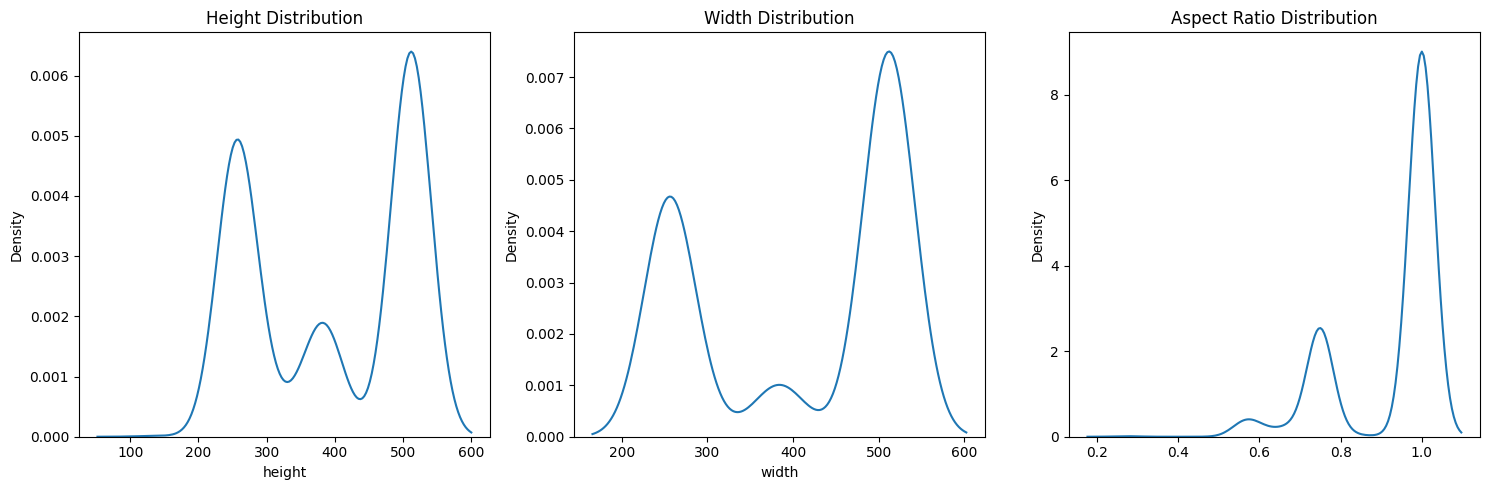

In [17]:
### Showing Distribution Of aspect ratio and size of images based on random sample

selected_idx = np.random.choice(df.shape[0], 1000)
dataset_preview = read_img(df.iloc[selected_idx,:], shape_info=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(dataset_preview['height'], ax=axes[0])
axes[0].set_title('Height Distribution')

sns.kdeplot(dataset_preview['width'], ax=axes[1])
axes[1].set_title('Width Distribution')

aspect_ratio = pd.DataFrame([dataset_preview['height'] / dataset_preview['width'],
                             dataset_preview['width'] / dataset_preview['height']]).min()
sns.kdeplot(aspect_ratio, ax=axes[2])
axes[2].set_title('Aspect Ratio Distribution')

plt.tight_layout()
plt.show()

In [18]:
### Encoding Labels into Numbers

from sklearn.preprocessing import LabelEncoder

categories = y.unique()
label_encoder = LabelEncoder()
encoded_categories = label_encoder.fit_transform(categories).tolist()
display(pd.DataFrame({'food': categories, 'encoded_label': encoded_categories}))

y = label_encoder.transform(y)

food  encoded_label
0      baked_potato              0
1           baklava              1
2      caesar_salad              2
3        cheesecake              4
4   cheese_sandwich              3
5           chicken              5
6     chicken_curry              6
7    chocolate_cake              7
8            donuts              8
9              eggs              9
10          falafel             10
11             fish             11
12     french_fries             12
13        hamburger             13
14          hot_dog             14
15        ice_cream             15
16          lasagna             16
17         omelette             17
18            pizza             18
19        spaghetti             19
20            steak             20
21            sushi             21

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Test set size:", len(X_test))

Training set size: 16858
Validation set size: 3613
Test set size: 3613


In [20]:
## Random Undersampling

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

## Number of samples in each categories
from collections import Counter
print(Counter(y_res))

Counter({0: 456, 1: 456, 2: 456, 3: 456, 4: 456, 5: 456, 6: 456, 7: 456, 8: 456, 9: 456, 10: 456, 11: 456, 12: 456, 13: 456, 14: 456, 15: 456, 16: 456, 17: 456, 18: 456, 19: 456, 20: 456, 21: 456})


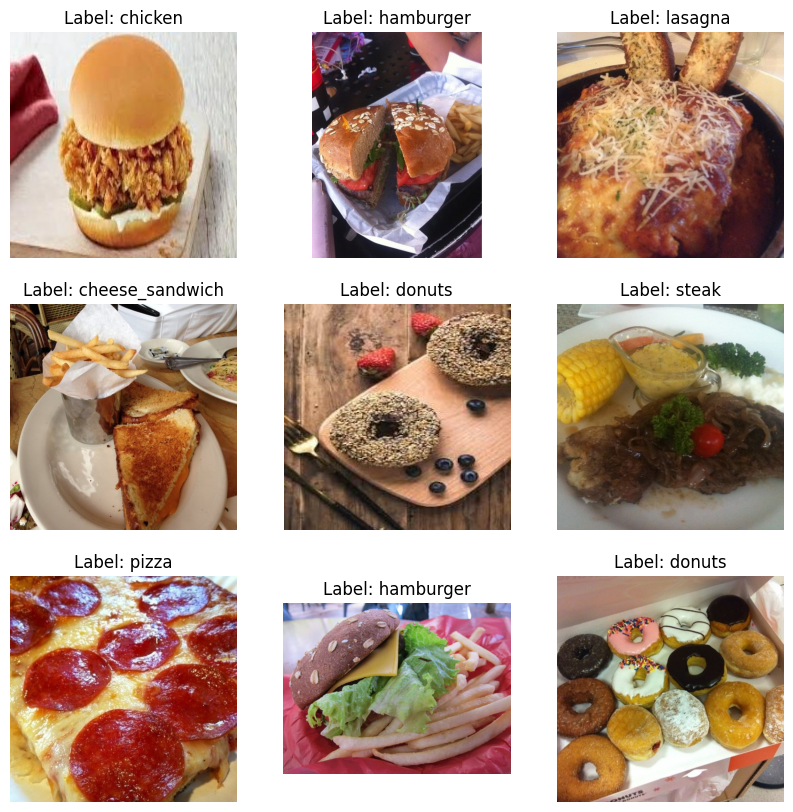

In [21]:
### Showing Some Images

selected_idx = np.random.choice(X_train.shape[0], 9)
plot_X = read_img(X_train.iloc[selected_idx, :])

plot_y = [sorted(categories)[label] for label in y_train[selected_idx]]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    image_rgb = cv2.cvtColor(plot_X['image'][i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

    plt.title(f"Label: {plot_y[i]}")
    plt.axis('off')
plt.show()

## Model

In [22]:
df_train = pd.DataFrame({'image_path': X_res.dest.tolist(), 'label': y_res.tolist()})
df_valid = pd.DataFrame({'image_path': X_valid.dest.tolist(), 'label': y_valid.tolist()})

train_generator = DataGenerator(dataframe=df_train, batch_size=batch_size, target_size=target_size)
valid_generator = DataGenerator(dataframe=df_valid, batch_size=batch_size, target_size=target_size)

#### Models

In [23]:
## VGG

model = VGG16(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_VGG_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_VGG_imagenet, model, 'VGG_imagenet')

2024-04-12 10:03:35.660378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 10:03:35.682782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 10:03:35.683063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,
2024-04-12 10:03:44.026976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-12 10:03:44.663641: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-12 10:03:45.109416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-12 10:03:45.286158: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1fc9bae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 10:03:45.286194: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, 

314/314 [==============================] - 72s 196ms/step - loss: 7.2844 - accuracy: 0.2924 - val_loss: 3.5879 - val_accuracy: 0.0321
Epoch 2/30
314/314 [==============================] - 59s 187ms/step - loss: 2.9376 - accuracy: 0.1040 - val_loss: 2.4976 - val_accuracy: 0.2369
Epoch 3/30
314/314 [==============================] - 57s 183ms/step - loss: 2.1615 - accuracy: 0.3412 - val_loss: 1.8256 - val_accuracy: 0.4564
Epoch 4/30
314/314 [==============================] - 60s 191ms/step - loss: 1.6312 - accuracy: 0.4967 - val_loss: 1.5038 - val_accuracy: 0.5455
Epoch 5/30
314/314 [==============================] - 58s 184ms/step - loss: 1.2848 - accuracy: 0.6109 - val_loss: 1.4054 - val_accuracy: 0.5887
Epoch 6/30
314/314 [==============================] - 56s 177ms/step - loss: 0.9870 - accuracy: 0.6963 - val_loss: 0.9690 - val_accuracy: 0.7191
Epoch 7/30
314/314 [==============================] - 58s 183ms/step - loss: 0.8003 - accuracy: 0.7541 - val_loss: 1.0310 - val_accuracy: 0.7

In [30]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters = 96, input_shape=(target_size[0], target_size[1], 3), kernel_size = (11, 11), strides = (4, 4), padding = 'valid'))

model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D(pool_size = (2, 2),
                       strides = (2, 2), padding = 'valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (11, 11),
                 strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3, 3),
			strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3, 3),
			strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3, 3),
			strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2),
			padding = 'valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Flattening
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, input_shape = (224*224*3, )))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Softmax Layer
model.add(Dense(len(categories)))
model.add(Activation('softmax'))

history_AlexNet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_AlexNet, model, 'AlexNet')

Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 65s 190ms/step - loss: 3.5758 - accuracy: 0.1177 - val_loss: 3.5752 - val_accuracy: 0.0673
Epoch 2/30
314/314 [==============================] - 56s 179ms/step - loss: 3.3261 - accuracy: 0.1507 - val_loss: 3.1013 - val_accuracy: 0.1539
Epoch 3/30
314/314 [==============================] - 56s 179ms/step - loss: 3.0943 - accuracy: 0.1753 - val_loss: 3.3398 - val_accuracy: 0.1486
Epoch 4/30
314/314 [==============================] - 59s 187ms/step - loss: 2.8929 - accuracy: 0.2109 - val_loss: 4.2708 - val_accuracy: 0.1345
Epoch 5/30
314/314 [==============================] - 59s 188ms/step - loss: 2.7338 - accuracy: 0.2418 - val_loss: 3.0171 - val_accuracy: 0.2375
Epoch 6/30
314/314 [==============================] - 59s 188ms/step - loss: 2.5885 - accuracy: 0.2752 - val_loss: 2.9127 - val_accuracy: 0.2466
Epoch 7/30
314/314 [==============================] - 58s 184ms/step - loss: 2.4282 - accuracy: 0.3126 - val_loss: 2.9189 - val_accuracy: 0.2

In [31]:
## ResNet50

model = ResNet50(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_ResNet50_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_ResNet50_imagenet, model, 'ResNet50_imagenet')

94765736/94765736 [==============================] - 6s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 91s 196ms/step - loss: 1.1288 - accuracy: 0.6777 - val_loss: 5.9586 - val_accuracy: 0.1019
Epoch 2/30
314/314 [==============================] - 58s 185ms/step - loss: 0.2507 - accuracy: 0.9330 - val_loss: 3.1128 - val_accuracy: 0.2079
Epoch 3/30
314/314 [==============================] - 60s 192ms/step - loss: 0.0846 - accuracy: 0.9789 - val_loss: 1.1316 - val_accuracy: 0.7066
Epoch 4/30
314/314 [==============================] - 59s 187ms/step - loss: 0.0523 - accuracy: 0.9864 - val_loss: 0.7916 - val_accuracy: 0.8010
Epoch 5/30
314/314 [==============================] - 60s 190ms/step - loss: 0.0597 - accuracy: 0.9843 - val_loss: 1.1822 - val_accuracy: 0.7293
Epoch 6/30
314/314 [==============================] - 56s 177ms/step - loss: 0.1112 - accuracy: 0.9672 - val_loss: 0.9524 - val_accuracy: 0.7592
Epoch 7/30
314/314 [==============================] - 60s 190ms/step - loss: 0.1034 - accuracy: 0.9670 - val_loss: 0.9366 - val_accuracy: 0.7

In [32]:
## ResNet101

model = ResNet101(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_ResNet101_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_ResNet101_imagenet, model, 'ResNet101_imagenet')

171446536/171446536 [==============================] - 8s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 118s 199ms/step - loss: 1.0715 - accuracy: 0.6885 - val_loss: 4.0051 - val_accuracy: 0.0399
Epoch 2/30
314/314 [==============================] - 61s 193ms/step - loss: 0.2438 - accuracy: 0.9303 - val_loss: 3.3588 - val_accuracy: 0.1805
Epoch 3/30
314/314 [==============================] - 60s 191ms/step - loss: 0.0820 - accuracy: 0.9789 - val_loss: 1.1566 - val_accuracy: 0.7108
Epoch 4/30
314/314 [==============================] - 59s 187ms/step - loss: 0.0458 - accuracy: 0.9881 - val_loss: 0.8079 - val_accuracy: 0.7966
Epoch 5/30
314/314 [==============================] - 60s 191ms/step - loss: 0.0952 - accuracy: 0.9715 - val_loss: 1.3912 - val_accuracy: 0.6911
Epoch 6/30
314/314 [==============================] - 60s 190ms/step - loss: 0.1167 - accuracy: 0.9654 - val_loss: 0.8187 - val_accuracy: 0.7982
Epoch 7/30
314/314 [==============================] - 59s 188ms/step - loss: 0.1029 - accuracy: 0.9689 - val_loss: 1.1176 - val_accuracy: 0.

In [33]:
## ResNet152

model = ResNet152(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_ResNet152_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_ResNet152_imagenet, model, 'ResNet152_imagenet')

234698864/234698864 [==============================] - 11s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 165s 253ms/step - loss: 1.0680 - accuracy: 0.6875 - val_loss: 4.0680 - val_accuracy: 0.1088
Epoch 2/30
314/314 [==============================] - 77s 244ms/step - loss: 0.2492 - accuracy: 0.9278 - val_loss: 4.2162 - val_accuracy: 0.1326
Epoch 3/30
314/314 [==============================] - 78s 247ms/step - loss: 0.0924 - accuracy: 0.9743 - val_loss: 1.4470 - val_accuracy: 0.6347
Epoch 4/30
314/314 [==============================] - 78s 247ms/step - loss: 0.0848 - accuracy: 0.9751 - val_loss: 0.8184 - val_accuracy: 0.8010
Epoch 5/30
314/314 [==============================] - 77s 245ms/step - loss: 0.0880 - accuracy: 0.9735 - val_loss: 0.7927 - val_accuracy: 0.7991
Epoch 6/30
314/314 [==============================] - 77s 245ms/step - loss: 0.1222 - accuracy: 0.9632 - val_loss: 0.8648 - val_accuracy: 0.7813
Epoch 7/30
314/314 [==============================] - 78s 247ms/step - loss: 0.0878 - accuracy: 0.9742 - val_loss: 0.7890 - val_accuracy: 0.

In [34]:
## InceptionV3

model = InceptionV3(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionV3_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_InceptionV3_imagenet, model, 'InceptionV3_imagenet')

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 94s 202ms/step - loss: 1.1889 - accuracy: 0.6616 - val_loss: 0.7115 - val_accuracy: 0.7930
Epoch 2/30
314/314 [==============================] - 59s 187ms/step - loss: 0.3202 - accuracy: 0.9073 - val_loss: 0.6819 - val_accuracy: 0.8024
Epoch 3/30
314/314 [==============================] - 59s 187ms/step - loss: 0.1098 - accuracy: 0.9725 - val_loss: 0.6282 - val_accuracy: 0.8314
Epoch 4/30
314/314 [==============================] - 59s 188ms/step - loss: 0.0617 - accuracy: 0.9846 - val_loss: 0.6183 - val_accuracy: 0.8356
Epoch 5/30
314/314 [==============================] - 58s 186ms/step - loss: 0.0479 - accuracy: 0.9867 - val_loss: 0.6937 - val_accuracy: 0.8182
Epoch 6/30
314/314 [==============================] - 56s 177ms/step - loss: 0.0842 - accuracy: 0.9749 - val_loss: 0.9381 - val_accuracy: 0.7888


In [35]:
## MobileNet

model = MobileNet(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_MobileNet_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_MobileNet_imagenet, model, 'MobileNet_imagenet')

17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 67s 177ms/step - loss: 1.3204 - accuracy: 0.6237 - val_loss: 0.7724 - val_accuracy: 0.7791
Epoch 2/30
314/314 [==============================] - 57s 181ms/step - loss: 0.4329 - accuracy: 0.8833 - val_loss: 0.6754 - val_accuracy: 0.7902
Epoch 3/30
314/314 [==============================] - 58s 185ms/step - loss: 0.1923 - accuracy: 0.9638 - val_loss: 0.5801 - val_accuracy: 0.8240
Epoch 4/30
314/314 [==============================] - 57s 182ms/step - loss: 0.0864 - accuracy: 0.9915 - val_loss: 0.5466 - val_accuracy: 0.8381
Epoch 5/30
314/314 [==============================] - 56s 177ms/step - loss: 0.0457 - accuracy: 0.9976 - val_loss: 0.5527 - val_accuracy: 0.8359
Epoch 6/30
314/314 [==============================] - 56s 179ms/step - loss: 0.0274 - accuracy: 0.9990 - val_loss: 0.5534 - val_accuracy: 0.8411
Epoch 7/30
314/314 [==============================] - 58s 184ms/step - loss: 0.0187 - accuracy: 0.9994 - val_loss: 0.5310 - val_accuracy: 0.8

In [36]:
## Xception

model = Xception(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_Xception_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_Xception_imagenet, model, 'Xception_imagenet')

83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 82s 189ms/step - loss: 1.2578 - accuracy: 0.6715 - val_loss: 0.5774 - val_accuracy: 0.8384
Epoch 2/30
314/314 [==============================] - 58s 186ms/step - loss: 0.2912 - accuracy: 0.9248 - val_loss: 0.4736 - val_accuracy: 0.8710
Epoch 3/30
314/314 [==============================] - 58s 183ms/step - loss: 0.0738 - accuracy: 0.9850 - val_loss: 0.4872 - val_accuracy: 0.8600
Epoch 4/30
314/314 [==============================] - 60s 191ms/step - loss: 0.0248 - accuracy: 0.9969 - val_loss: 0.4882 - val_accuracy: 0.8732
Epoch 5/30
314/314 [==============================] - 58s 185ms/step - loss: 0.0133 - accuracy: 0.9987 - val_loss: 0.5156 - val_accuracy: 0.8688
Epoch 6/30
314/314 [==============================] - 58s 185ms/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.5245 - val_accuracy: 0.8647
Epoch 7/30
314/314 [==============================] - 58s 183ms/step - loss: 0.0119 - accuracy: 0.9977 - val_loss: 0.5508 - val_accuracy: 0.8

In [37]:
## InceptionResNetV2

model = InceptionResNetV2(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionResNetV2_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_InceptionResNetV2_imagenet, model, 'InceptionResNetV2_imagenet')

219055592/219055592 [==============================] - 10s 0us/step


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
314/314 [==============================] - 135s 203ms/step - loss: 1.0190 - accuracy: 0.7106 - val_loss: 0.5747 - val_accuracy: 0.8381
Epoch 2/30
314/314 [==============================] - 59s 186ms/step - loss: 0.2314 - accuracy: 0.9353 - val_loss: 0.5260 - val_accuracy: 0.8536
Epoch 3/30
314/314 [==============================] - 60s 190ms/step - loss: 0.0836 - accuracy: 0.9760 - val_loss: 0.6134 - val_accuracy: 0.8392
Epoch 4/30
314/314 [==============================] - 61s 193ms/step - loss: 0.0518 - accuracy: 0.9852 - val_loss: 0.7485 - val_accuracy: 0.8198
Epoch 5/30
314/314 [==============================] - 59s 186ms/step - loss: 0.0578 - accuracy: 0.9829 - val_loss: 0.8587 - val_accuracy: 0.8115
Epoch 6/30
314/314 [==============================] - 59s 189ms/step - loss: 0.0402 - accuracy: 0.9888 - val_loss: 1.8163 - val_accuracy: 0.8140


In [38]:
## DenseNet121

model = DenseNet121(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet121_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_DenseNet121_imagenet, model, 'DenseNet121_imagenet')

29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


314/314 [==============================] - 119s 206ms/step - loss: 1.1233 - accuracy: 0.6870 - val_loss: 0.5740 - val_accuracy: 0.8420
Epoch 2/30
314/314 [==============================] - 57s 180ms/step - loss: 0.3240 - accuracy: 0.9146 - val_loss: 0.5500 - val_accuracy: 0.8406
Epoch 3/30
314/314 [==============================] - 58s 185ms/step - loss: 0.1104 - accuracy: 0.9781 - val_loss: 0.4576 - val_accuracy: 0.8655
Epoch 4/30
314/314 [==============================] - 58s 184ms/step - loss: 0.0399 - accuracy: 0.9960 - val_loss: 0.4368 - val_accuracy: 0.8738
Epoch 5/30
314/314 [==============================] - 56s 178ms/step - loss: 0.0249 - accuracy: 0.9980 - val_loss: 0.4681 - val_accuracy: 0.8746
Epoch 6/30
314/314 [==============================] - 59s 189ms/step - loss: 0.0188 - accuracy: 0.9976 - val_loss: 0.5336 - val_accuracy: 0.8619
Epoch 7/30
314/314 [==============================] - 58s 184ms/step - loss: 0.0180 - accuracy: 0.9983 - val_loss: 0.6069 - val_accuracy: 0.

In [39]:
## DenseNet169

model = DenseNet169(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet169_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_DenseNet169_imagenet, model, 'DenseNet169_imagenet')

51877672/51877672 [==============================] - 3s 0us/step


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
314/314 [==============================] - 136s 196ms/step - loss: 0.9563 - accuracy: 0.7342 - val_loss: 0.5338 - val_accuracy: 0.8483
Epoch 2/30
314/314 [==============================] - 61s 194ms/step - loss: 0.2327 - accuracy: 0.9386 - val_loss: 0.4948 - val_accuracy: 0.8525
Epoch 3/30
314/314 [==============================] - 60s 189ms/step - loss: 0.0709 - accuracy: 0.9872 - val_loss: 0.4386 - val_accuracy: 0.8799
Epoch 4/30
314/314 [==============================] - 63s 199ms/step - loss: 0.0322 - accuracy: 0.9942 - val_loss: 0.5469 - val_accuracy: 0.8469
Epoch 5/30
314/314 [==============================] - 61s 196ms/step - loss: 0.0317 - accuracy: 0.9935 - val_loss: 0.5003 - val_accuracy: 0.8616
Epoch 6/30
314/314 [==============================] - 64s 205ms/step - loss: 0.0470 - accuracy: 0.9887 - val_loss: 0.6607 - val_accuracy: 0.8309


In [40]:
## DenseNet201

model = DenseNet201(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet201_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_DenseNet201_imagenet, model, 'DenseNet201_imagenet')

74836368/74836368 [==============================] - 4s 0us/step


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
314/314 [==============================] - 167s 235ms/step - loss: 0.9004 - accuracy: 0.7463 - val_loss: 0.5305 - val_accuracy: 0.8536
Epoch 2/30
314/314 [==============================] - 69s 219ms/step - loss: 0.1977 - accuracy: 0.9489 - val_loss: 0.4716 - val_accuracy: 0.8600
Epoch 3/30
314/314 [==============================] - 69s 219ms/step - loss: 0.0543 - accuracy: 0.9896 - val_loss: 0.4141 - val_accuracy: 0.8799
Epoch 4/30
314/314 [==============================] - 68s 215ms/step - loss: 0.0235 - accuracy: 0.9963 - val_loss: 0.4008 - val_accuracy: 0.8923
Epoch 5/30
314/314 [==============================] - 65s 207ms/step - loss: 0.0211 - accuracy: 0.9963 - val_loss: 0.4808 - val_accuracy: 0.8796
Epoch 6/30
314/314 [==============================] - 66s 209ms/step - loss: 0.0353 - accuracy: 0.9908 - val_loss: 0.5464 - val_accuracy: 0.8500
Epoch 7/30
314/314 [==============================] - 65s 207ms/step - loss: 0.0939 - accuracy: 0.9715 - val_loss: 0.6719 - val_a

## Model Evaluation

In [41]:
## Loading Saved Models

VGG_imagenet, history_VGG_imagenet= Load_Model(saving_path, 'VGG_imagenet')
AlexNet_imagenet, history_AlexNet_imagenet= Load_Model(saving_path, 'AlexNet')
ResNet50_imagenet, history_ResNet50_imagenet= Load_Model(saving_path, 'ResNet50_imagenet')
ResNet101_imagenet, history_ResNet101_imagenet= Load_Model(saving_path, 'ResNet101_imagenet')
ResNet152_imagenet, history_ResNet152_imagenet= Load_Model(saving_path, 'ResNet152_imagenet')
InceptionV3_imagenet, history_InceptionV3_imagenet= Load_Model(saving_path, 'InceptionV3_imagenet')
MobileNet_imagenet, history_MobileNet_imagenet= Load_Model(saving_path, 'MobileNet_imagenet')
Xception_imagenet, history_Xception_imagenet= Load_Model(saving_path, 'Xception_imagenet')
InceptionResNetV2_imagenet, history_InceptionResNetV2_imagenet= Load_Model(saving_path, 'InceptionResNetV2_imagenet')
DenseNet121_imagenet, history_DenseNet121_imagenet= Load_Model(saving_path, 'DenseNet121_imagenet')
DenseNet169_imagenet, history_DenseNet169_imagenet= Load_Model(saving_path, 'DenseNet169_imagenet')
DenseNet201_imagenet, history_DenseNet201_imagenet= Load_Model(saving_path, 'DenseNet201_imagenet')

#### Train Validation Accuracy

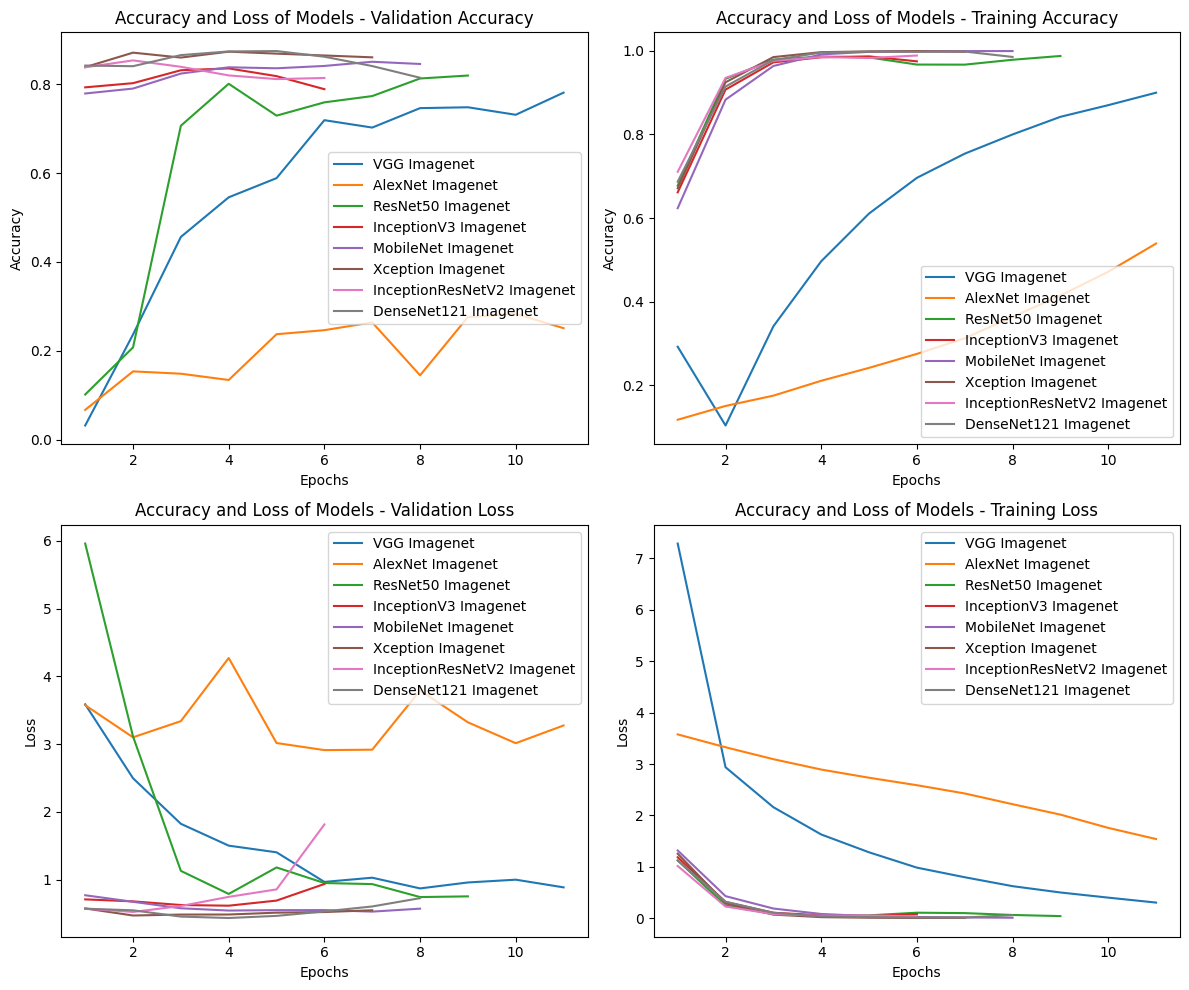

In [42]:
models_hist = [history_VGG_imagenet, history_AlexNet_imagenet, history_ResNet50_imagenet,
               history_InceptionV3_imagenet, history_MobileNet_imagenet, history_Xception_imagenet,
               history_InceptionResNetV2_imagenet, history_DenseNet121_imagenet]

models_name = ['VGG Imagenet', 'AlexNet Imagenet', 'ResNet50 Imagenet',
               'InceptionV3 Imagenet', 'MobileNet Imagenet', 'Xception Imagenet',
               'InceptionResNetV2 Imagenet', 'DenseNet121 Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy and Loss of Models')

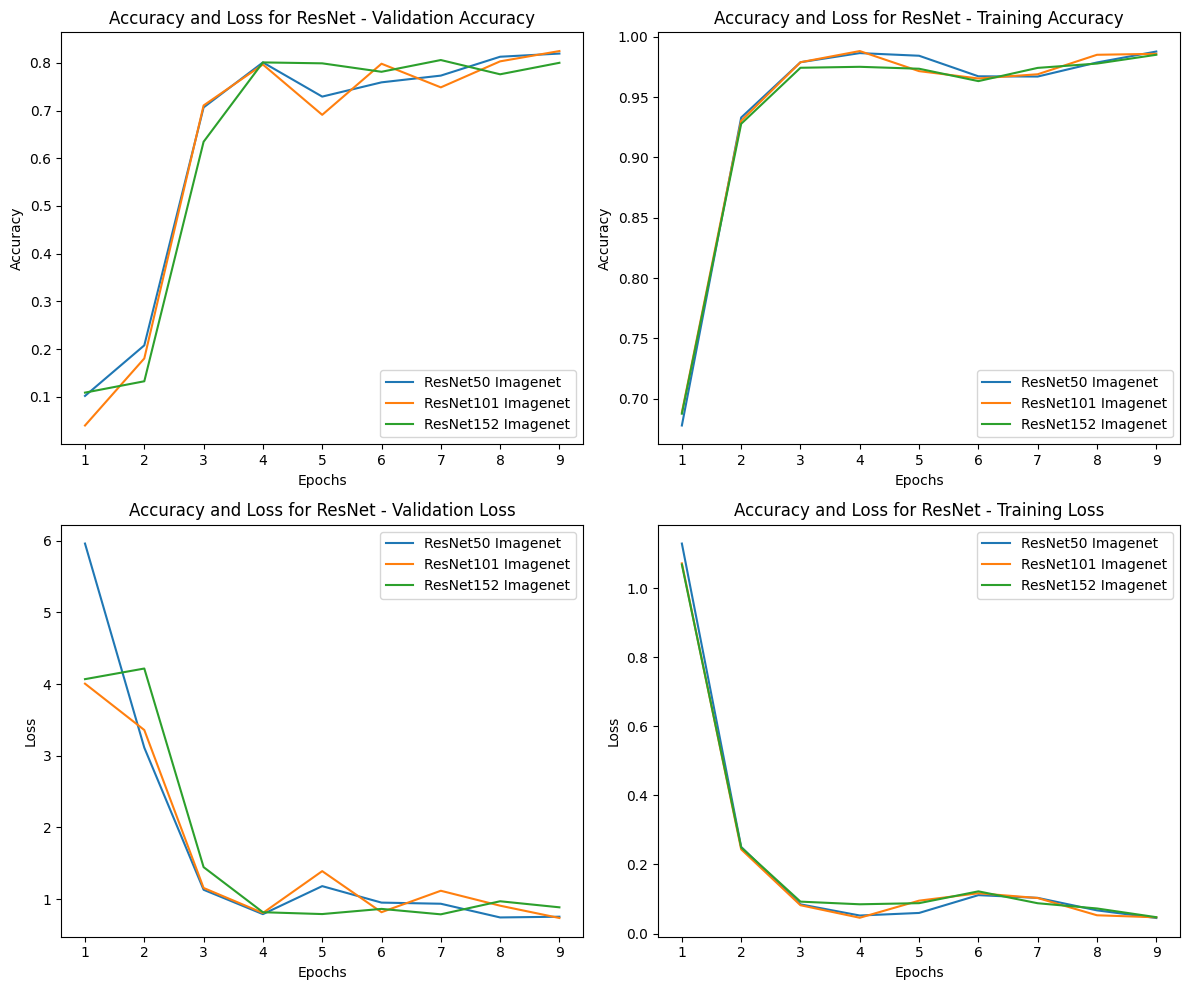

In [43]:
models_hist = [history_ResNet50_imagenet, history_ResNet101_imagenet, history_ResNet152_imagenet]

models_name = ['ResNet50 Imagenet', 'ResNet101 Imagenet', 'ResNet152 Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy and Loss for ResNet')

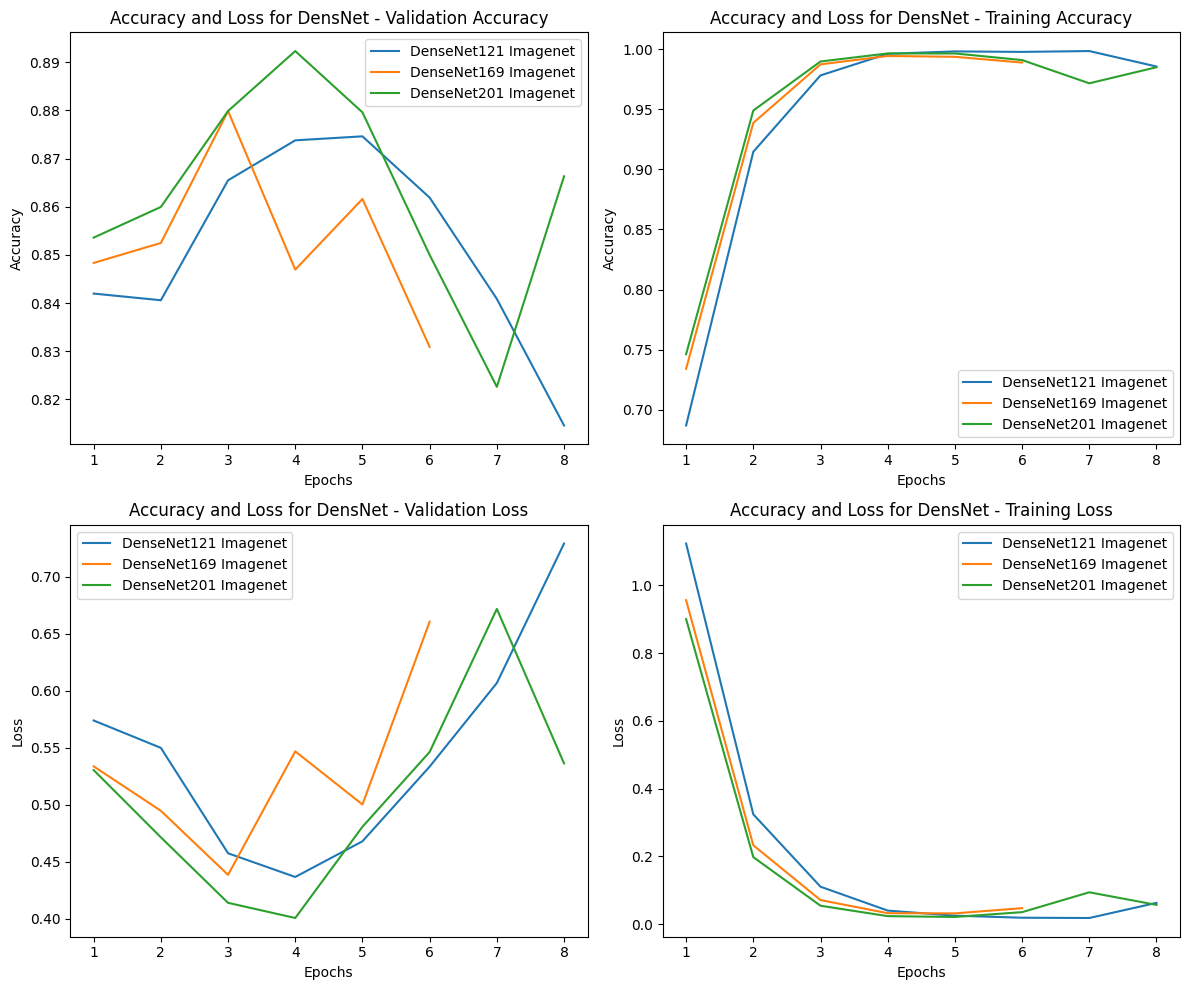

In [44]:
models_hist = [history_DenseNet121_imagenet, history_DenseNet169_imagenet, history_DenseNet201_imagenet]

models_name = ['DenseNet121 Imagenet', 'DenseNet169 Imagenet', 'DenseNet201 Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy and Loss for DensNet')

#### Confusion Matrix

In [45]:
valid_generator = DataGenerator(dataframe=df_valid, batch_size=512, target_size=target_size)

1/1 [==============================] - 1s 666ms/step


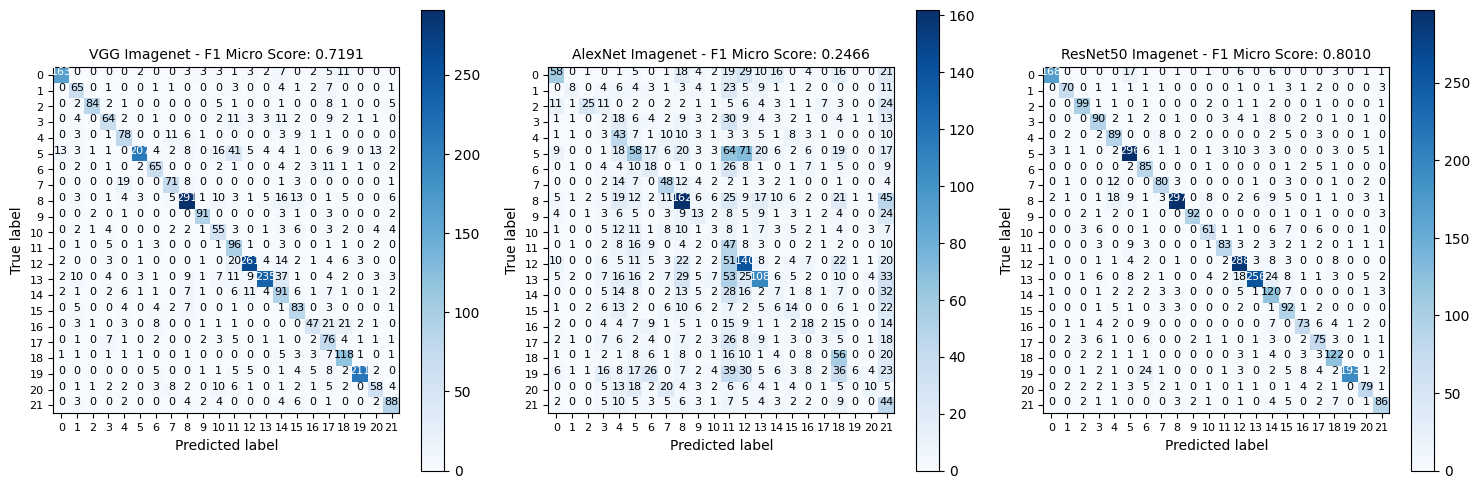

In [46]:
models = [VGG_imagenet, AlexNet_imagenet, ResNet50_imagenet]

models_name = ['VGG Imagenet', 'AlexNet Imagenet', 'ResNet50 Imagenet']

true_labels, pred_labels = evaluate_models(models, valid_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

1/1 [==============================] - 1s 529ms/step


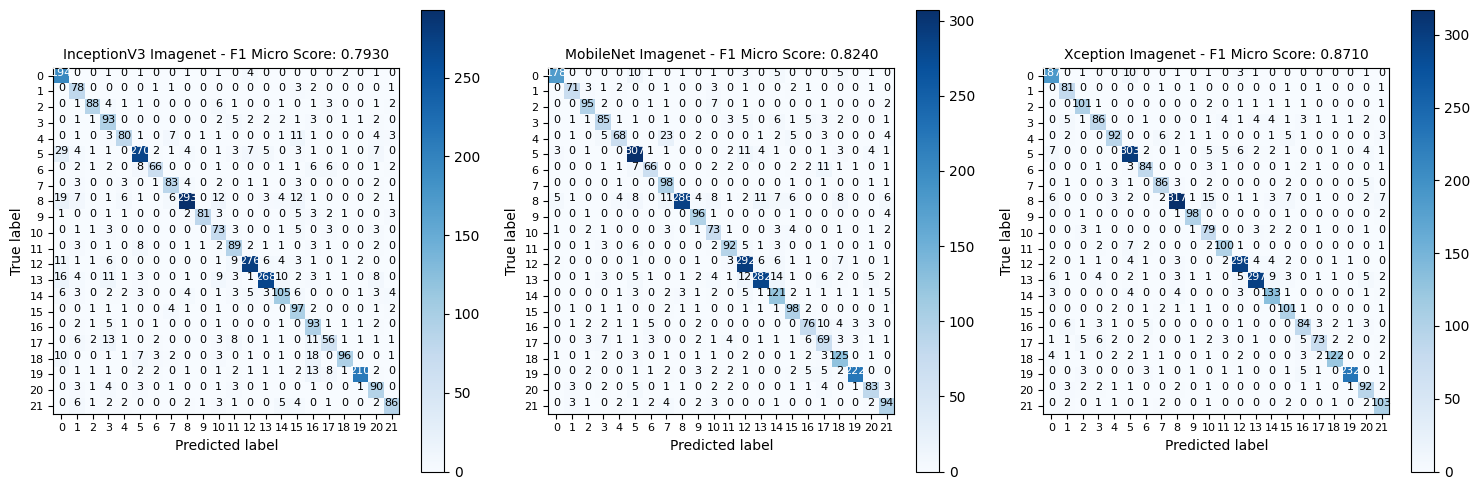

In [47]:
models = [InceptionV3_imagenet, MobileNet_imagenet, Xception_imagenet]

models_name = ['InceptionV3 Imagenet', 'MobileNet Imagenet', 'Xception Imagenet']

true_labels, pred_labels = evaluate_models(models, valid_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

1/1 [==============================] - 2s 2s/step


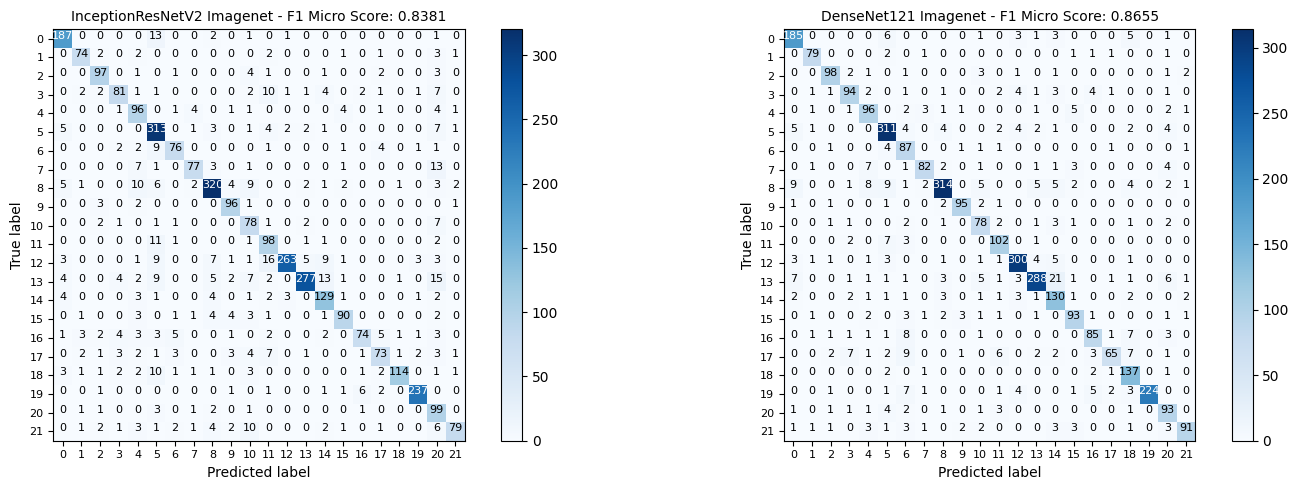

In [48]:
models = [InceptionResNetV2_imagenet, DenseNet121_imagenet]

models_name = ['InceptionResNetV2 Imagenet', 'DenseNet121 Imagenet']

true_labels, pred_labels = evaluate_models(models, valid_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

1/1 [==============================] - 2s 2s/step


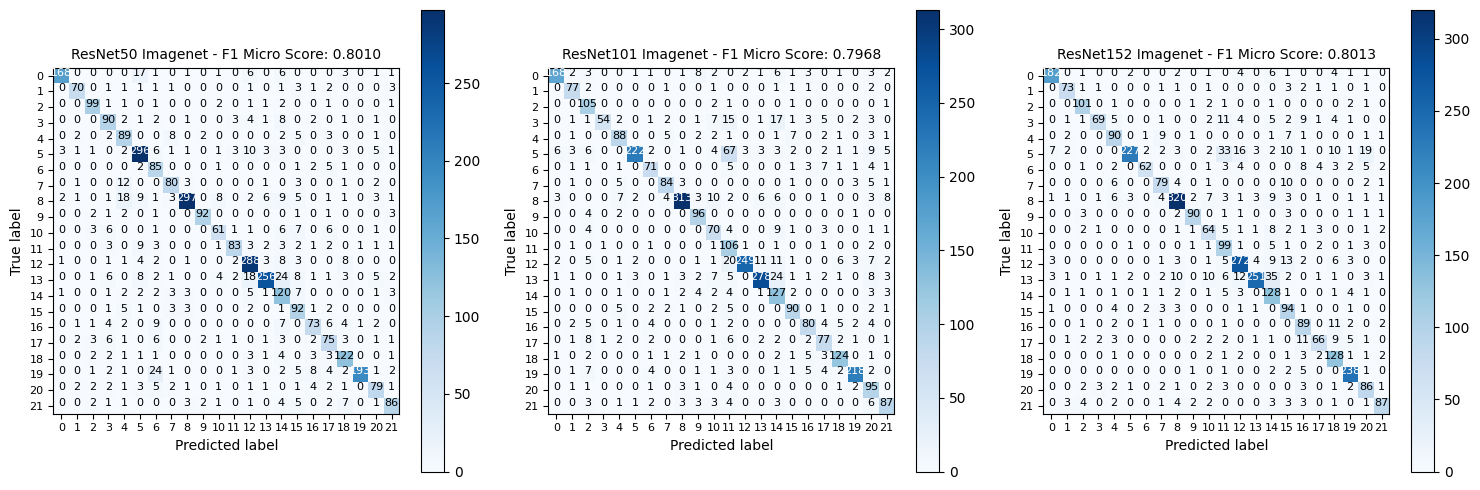

In [49]:
models = [ResNet50_imagenet, ResNet101_imagenet, ResNet152_imagenet]

models_name = ['ResNet50 Imagenet', 'ResNet101 Imagenet', 'ResNet152 Imagenet']

true_labels, pred_labels = evaluate_models(models, valid_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

1/1 [==============================] - 3s 3s/step


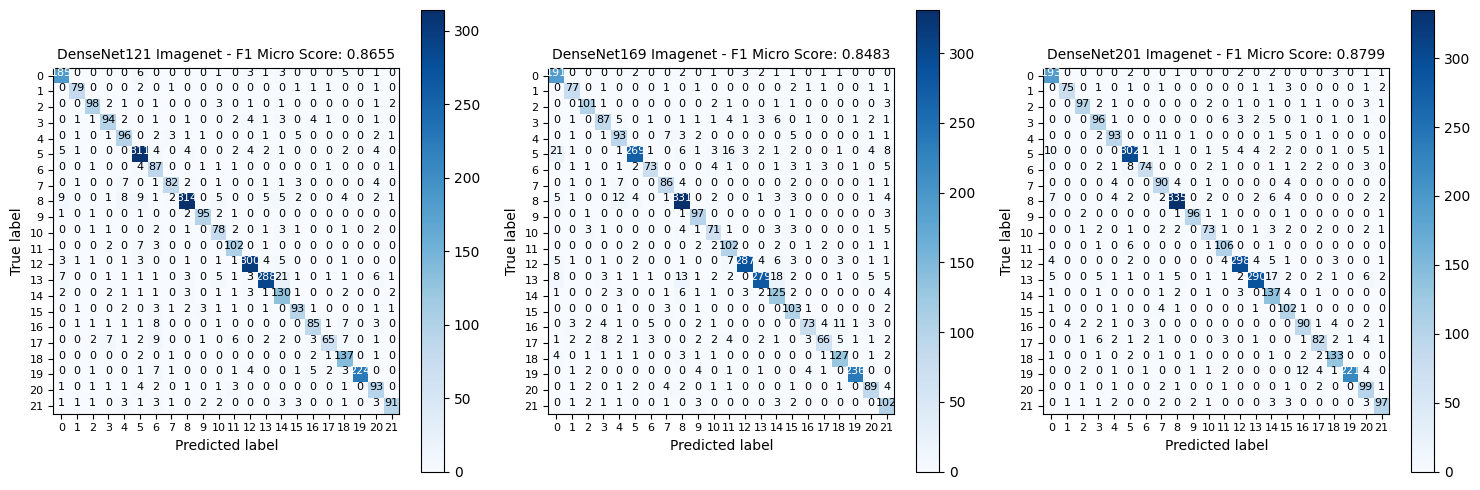

In [50]:
models = [DenseNet121_imagenet, DenseNet169_imagenet, DenseNet201_imagenet]

models_name = ['DenseNet121 Imagenet', 'DenseNet169 Imagenet', 'DenseNet201 Imagenet']

true_labels, pred_labels = evaluate_models(models, valid_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

## Using Data Augmentation

In [57]:
# label_in_array = np.eye(len(categories))
min_class_index = np.argmin(list(Counter(y_train).values()))
min_size = min(list(Counter(y_train).values()))
max_size = max(list(Counter(y_train).values()))

sampling_strategy = 0.5

ratio = {class_label: sampling_strategy*max_size/Counter(y_train)[class_label] for class_label in range(len(categories))}

for num in np.where(np.array(list(Counter(y_train).values())) * sampling_strategy < min_size)[0]:
    ratio[list(Counter(y_train).keys())[num]] = 1

target_balance_ratios = {class_label: int(max(Counter(y_train)[class_label]*ratio[class_label], min_size))  for class_label in range(len(categories))}

rus = RandomUnderSampler(random_state=42, sampling_strategy=target_balance_ratios)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Print the distribution of classes after undersampling
print("Distribution of classes after undersampling:")
print(Counter(y_res))

Distribution of classes after undersampling:
Counter({0: 833, 5: 833, 8: 833, 12: 833, 13: 833, 19: 833, 14: 743, 18: 603, 6: 523, 17: 514, 10: 511, 9: 506, 1: 498, 16: 493, 11: 488, 20: 488, 3: 486, 7: 486, 2: 479, 15: 477, 21: 460, 4: 456})


In [58]:
aug_path = aug_saving_path + "augmented_images"

In [59]:
max_samples = max(list(Counter(y_res).values()))
augmented_images, augmented_labels = augment_data(X_res, y_res, max_samples)

for label in categories:
    os.makedirs(os.path.join(aug_path, str(label)), exist_ok=True)

for image, label in zip(augmented_images, augmented_labels):
    label = categories[encoded_categories.index(label)]

    directory = os.path.join(aug_path, str(label))
    filename = f"image_{len(os.listdir(directory))}.png"
    cv2.imwrite(os.path.join(directory, filename), image)

In [60]:
data = []

for folders, _, files in os.walk(aug_path):
    for file in files:
        folder_name = folders.split('/')[-1]
        dest = f'{folders}/{file}'
        data.append({'name': file, 'label': folder_name, 'dest': dest})

df_aug = pd.DataFrame(data)

y_aug = df_aug['label']
y_aug = label_encoder.transform(y_aug)

X_aug = df_aug.drop(columns = ['label'])

print(Counter(y_aug))

Counter({4: 377, 21: 373, 15: 356, 2: 354, 3: 347, 7: 347, 11: 345, 20: 345, 16: 340, 1: 335, 9: 327, 10: 322, 17: 319, 6: 310, 18: 230, 14: 90})


In [61]:
X_aug = pd.concat([X_aug, X_res])
y_aug = np.append(y_aug, y_res)

print(Counter(y_aug))

Counter({1: 833, 2: 833, 4: 833, 3: 833, 6: 833, 7: 833, 9: 833, 10: 833, 11: 833, 14: 833, 15: 833, 16: 833, 17: 833, 18: 833, 20: 833, 21: 833, 0: 833, 5: 833, 8: 833, 12: 833, 13: 833, 19: 833})


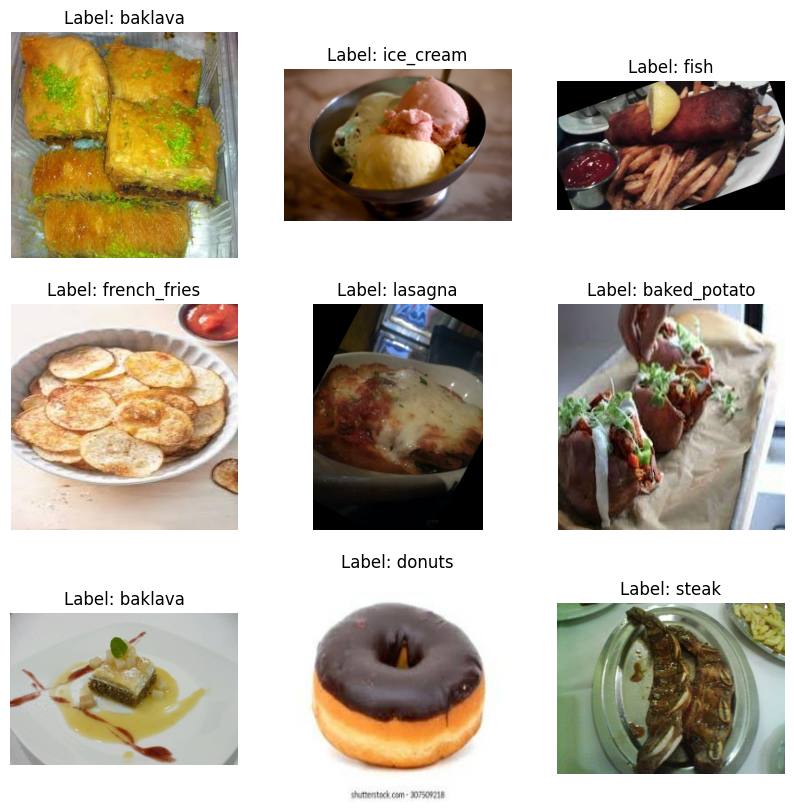

In [62]:
### Showing Some Images

selected_idx = np.random.choice(X_aug.shape[0], 9)
plot_X = read_img(X_aug.iloc[selected_idx, :])

plot_y = [sorted(categories)[label] for label in y_aug[selected_idx]]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    image_rgb = cv2.cvtColor(plot_X['image'][i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

    plt.title(f"Label: {plot_y[i]}")
    plt.axis('off')
plt.show()

## Continue On Selected Models

In [63]:
df_train = pd.DataFrame({'image_path': X_aug.dest.tolist(), 'label': y_aug.tolist()})
df_valid = pd.DataFrame({'image_path': X_valid.dest.tolist(), 'label': y_valid.tolist()})

train_generator = DataGenerator(dataframe=df_train, batch_size=batch_size, target_size=target_size)
valid_generator = DataGenerator(dataframe=df_valid, batch_size=batch_size, target_size=target_size)

### Models

In [64]:
## InceptionV3

model = InceptionV3(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionV3_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_InceptionV3_imagenet, model, 'InceptionV3_augmented_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
573/573 [==============================] - 143s 205ms/step - loss: 2.8558 - accuracy: 0.1363 - val_loss: 3.2748 - val_accuracy: 0.0299
Epoch 2/30
573/573 [==============================] - 113s 197ms/step - loss: 3.0350 - accuracy: 0.0778 - val_loss: 2.7846 - val_accuracy: 0.2732
Epoch 3/30
573/573 [==============================] - 115s 201ms/step - loss: 0.9404 - accuracy: 0.7338 - val_loss: 0.6120 - val_accuracy: 0.8273
Epoch 4/30
573/573 [==============================] - 115s 200ms/step - loss: 0.2664 - accuracy: 0.9242 - val_loss: 0.6803 - val_accuracy: 0.8170
Epoch 5/30
573/573 [==============================] - 117s 204ms/step - loss: 0.1125 - accuracy: 0.9664 - val_loss: 0.6636 - val_accuracy: 0.8306
Epoch 6/30
573/573 [==============================] - 110s 193ms/step - loss: 0.0689 - accuracy: 0.9799 - val_loss: 0.6835 - val_accuracy: 0.8306
Epoch 7/30
573/573 [==============================] - 115s 200ms/step - loss: 0.0673 - accuracy: 0.9787 - val_loss: 0.7741 -

In [65]:
## Xception

model = Xception(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_Xception_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_Xception_imagenet, model, 'Xception_augmented_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
573/573 [==============================] - 140s 204ms/step - loss: 0.9016 - accuracy: 0.7600 - val_loss: 0.4774 - val_accuracy: 0.8635
Epoch 2/30
573/573 [==============================] - 111s 194ms/step - loss: 0.1624 - accuracy: 0.9577 - val_loss: 0.4314 - val_accuracy: 0.8771
Epoch 3/30
573/573 [==============================] - 115s 201ms/step - loss: 0.0454 - accuracy: 0.9901 - val_loss: 0.4414 - val_accuracy: 0.8838
Epoch 4/30
573/573 [==============================] - 113s 197ms/step - loss: 0.0212 - accuracy: 0.9961 - val_loss: 0.4882 - val_accuracy: 0.8799
Epoch 5/30
573/573 [==============================] - 113s 198ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 0.5235 - val_accuracy: 0.8680
Epoch 6/30
573/573 [==============================] - 117s 203ms/step - loss: 0.0270 - accuracy: 0.9929 - val_loss: 0.5942 - val_accuracy: 0.8622


In [66]:
## DenseNet201

model = DenseNet201(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet201_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_DenseNet201_imagenet, model, 'DenseNet201_augmented_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
573/573 [==============================] - 212s 221ms/step - loss: 0.6397 - accuracy: 0.8224 - val_loss: 0.4105 - val_accuracy: 0.8810
Epoch 2/30
573/573 [==============================] - 117s 204ms/step - loss: 0.1226 - accuracy: 0.9693 - val_loss: 0.4196 - val_accuracy: 0.8829
Epoch 3/30
573/573 [==============================] - 118s 206ms/step - loss: 0.0496 - accuracy: 0.9880 - val_loss: 0.5240 - val_accuracy: 0.8627
Epoch 4/30
573/573 [==============================] - 115s 200ms/step - loss: 0.0501 - accuracy: 0.9859 - val_loss: 0.4218 - val_accuracy: 0.8904
Epoch 5/30
573/573 [==============================] - 119s 207ms/step - loss: 0.0506 - accuracy: 0.9859 - val_loss: 0.6084 - val_accuracy: 0.8508
Epoch 6/30
573/573 [==============================] - 116s 203ms/step - loss: 0.0566 - accuracy: 0.9835 - val_loss: 0.5805 - val_accuracy: 0.8558


In [67]:
## InceptionResNetV2

model = InceptionResNetV2(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionResNetV2_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_InceptionResNetV2_imagenet, model, 'InceptionResNetV2_augmented_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
573/573 [==============================] - 193s 214ms/step - loss: 0.7252 - accuracy: 0.7930 - val_loss: 0.5016 - val_accuracy: 0.8583
Epoch 2/30
573/573 [==============================] - 114s 199ms/step - loss: 0.1491 - accuracy: 0.9581 - val_loss: 0.5275 - val_accuracy: 0.8561
Epoch 3/30
573/573 [==============================] - 117s 203ms/step - loss: 0.0696 - accuracy: 0.9817 - val_loss: 0.9296 - val_accuracy: 0.8265
Epoch 4/30
573/573 [==============================] - 119s 208ms/step - loss: 0.0572 - accuracy: 0.9829 - val_loss: 0.5796 - val_accuracy: 0.8503
Epoch 5/30
573/573 [==============================] - 116s 202ms/step - loss: 0.0488 - accuracy: 0.9847 - val_loss: 0.6689 - val_accuracy: 0.8445
Epoch 6/30
573/573 [==============================] - 118s 205ms/step - loss: 0.0416 - accuracy: 0.9872 - val_loss: 1.0346 - val_accuracy: 0.8345


In [68]:
## MobileNet

model = MobileNet(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_MobileNet_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_MobileNet_imagenet, model, 'MobileNet_augmented_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
573/573 [==============================] - 126s 200ms/step - loss: 0.9770 - accuracy: 0.7178 - val_loss: 0.6563 - val_accuracy: 0.8090
Epoch 2/30
573/573 [==============================] - 110s 193ms/step - loss: 0.2760 - accuracy: 0.9310 - val_loss: 0.5912 - val_accuracy: 0.8276
Epoch 3/30
573/573 [==============================] - 115s 200ms/step - loss: 0.1069 - accuracy: 0.9804 - val_loss: 0.4969 - val_accuracy: 0.8525
Epoch 4/30
573/573 [==============================] - 107s 187ms/step - loss: 0.0437 - accuracy: 0.9954 - val_loss: 0.5201 - val_accuracy: 0.8539
Epoch 5/30
573/573 [==============================] - 112s 195ms/step - loss: 0.0232 - accuracy: 0.9980 - val_loss: 0.4935 - val_accuracy: 0.8602
Epoch 6/30
573/573 [==============================] - 111s 194ms/step - loss: 0.0161 - accuracy: 0.9989 - val_loss: 0.5196 - val_accuracy: 0.8627
Epoch 7/30
573/573 [==============================] - 111s 193ms/step - loss: 0.0128 - accuracy: 0.9989 - val_loss: 0.5789 -

### Evaluation

In [115]:
InceptionV3_augmented_imagenet, history_InceptionV3_augmented_imagenet= Load_Model(saving_path, 'InceptionV3_augmented_imagenet')
Xception_augmented_imagenet, history_Xception_augmented_imagenet= Load_Model(saving_path, 'Xception_augmented_imagenet')
DenseNet201_augmented_imagenet, history_DenseNet201_augmented_imagenet= Load_Model(saving_path, 'DenseNet201_augmented_imagenet')
InceptionResNetV2_augmented_imagenet, history_InceptionResNetV2_augmented_imagenet= Load_Model(saving_path, 'InceptionResNetV2_augmented_imagenet')
MobileNet_augmented_imagenet, history_MobileNet_augmented_imagenet= Load_Model(saving_path, 'MobileNet_augmented_imagenet')

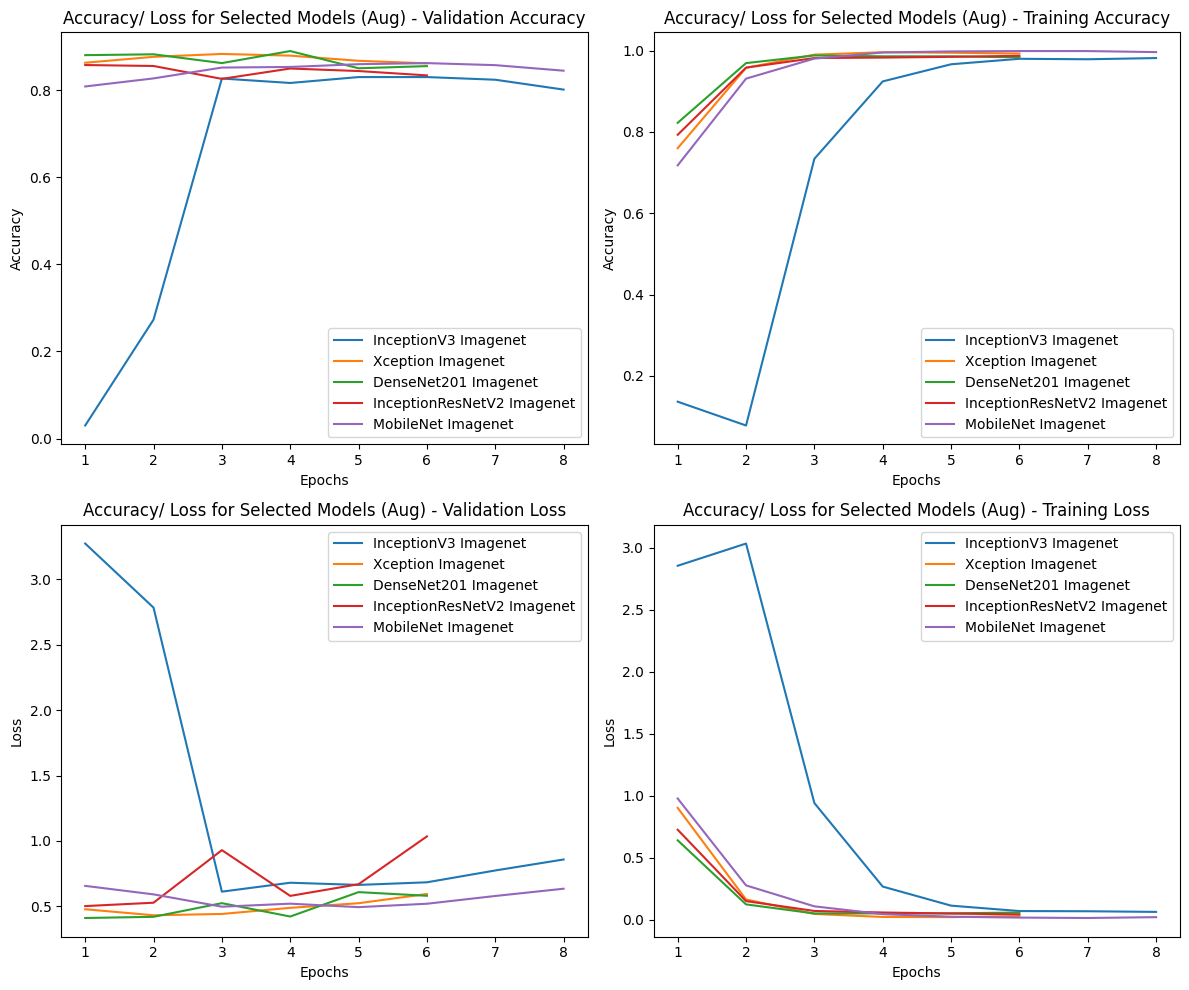

In [70]:
models_hist = [history_InceptionV3_augmented_imagenet, history_Xception_augmented_imagenet, history_DenseNet201_augmented_imagenet,
              history_InceptionResNetV2_augmented_imagenet, history_MobileNet_augmented_imagenet]

models_name = ['InceptionV3 Imagenet', 'Xception Imagenet', 'DenseNet201 Imagenet',
              'InceptionResNetV2 Imagenet', 'MobileNet Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy/ Loss for Selected Models (Aug)')

In [71]:
valid_generator = DataGenerator(dataframe=df_valid, batch_size=512, target_size=target_size)

In [72]:
models = [InceptionV3_augmented_imagenet, Xception_augmented_imagenet, DenseNet201_augmented_imagenet,
          InceptionResNetV2_augmented_imagenet, MobileNet_augmented_imagenet]
models_name = ['InceptionV3 Imagenet', 'Xception Imagenet', 'DenseNet201 Imagenet', 'InceptionResNetV2 Imagenet', 'MobileNet Imagenet']

true_labels, pred_labels = evaluate_models(models, valid_generator)


1/1 [==============================] - 0s 309ms/step


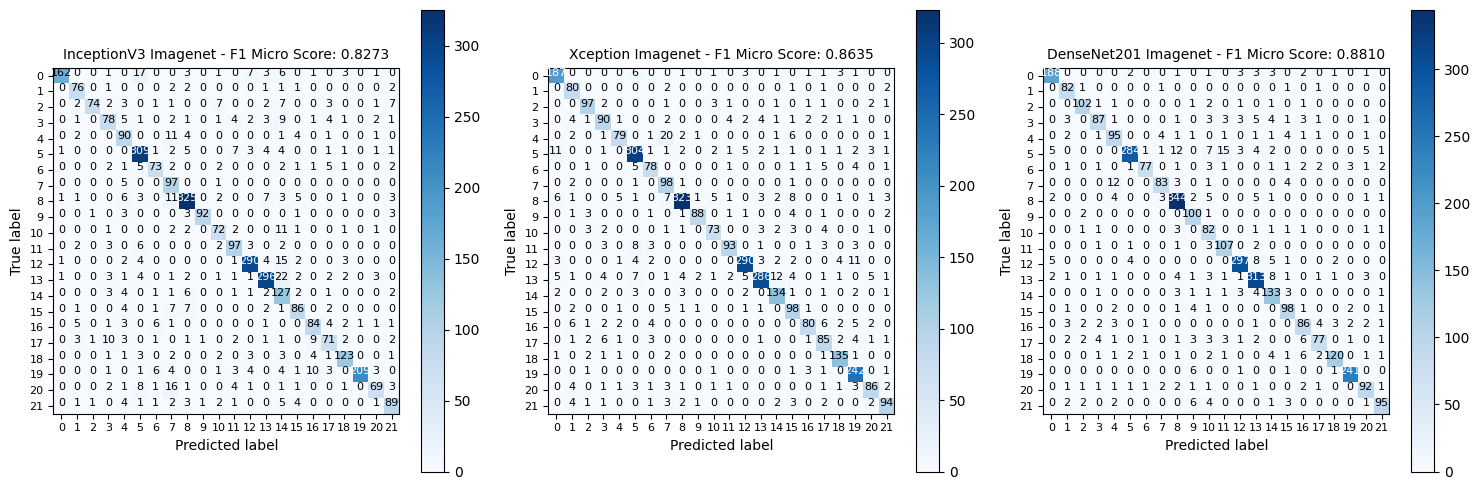

In [73]:
plot_confusion_matrix(true_labels[:3], pred_labels[:3], models_name[:3])

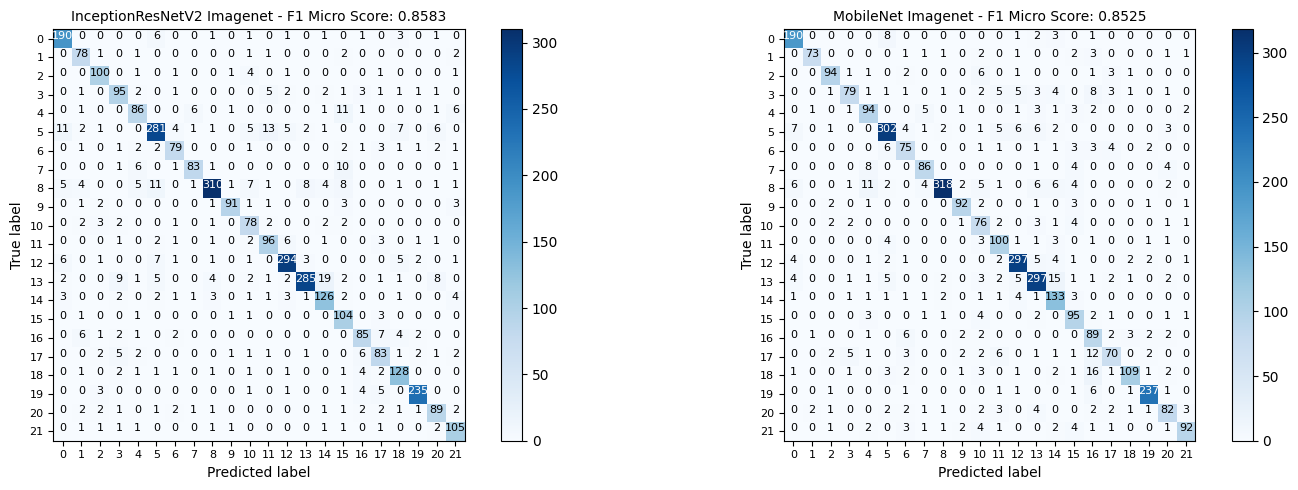

In [74]:
plot_confusion_matrix(true_labels[3:], pred_labels[3:], models_name[3:])

## Checking Misclassified Images

In [76]:
classification_result_aug = pd.DataFrame([np.array(pred_labels[0]) == np.array(true_labels[0]).astype(int),
                       np.array(pred_labels[1]) == np.array(true_labels[1]).astype(int),
                       np.array(pred_labels[2]) == np.array(true_labels[2]).astype(int),
                       np.array(pred_labels[3]) == np.array(true_labels[3]).astype(int),
                       np.array(pred_labels[4]) == np.array(true_labels[4]).astype(int)])
all_classifiers_wrong_predicted_aug = np.where(classification_result_aug.sum() == 0)[0]
all_classifiers_wrong_predicted_aug

array([  29,   30,   78,  124,  195,  226,  238,  254,  314,  352,  354,
        361,  374,  382,  438,  442,  460,  462,  477,  510,  548,  551,
        585,  734,  764,  781,  802,  806,  835,  836,  859,  954,  961,
        994,  995, 1024, 1026, 1030, 1051, 1066, 1121, 1160, 1185, 1192,
       1213, 1215, 1241, 1302, 1323, 1337, 1338, 1341, 1360, 1398, 1446,
       1463, 1466, 1469, 1483, 1488, 1516, 1529, 1567, 1578, 1609, 1620,
       1633, 1636, 1654, 1685, 1687, 1692, 1701, 1734, 1738, 1788, 1801,
       1820, 1828, 1832, 1857, 1869, 1870, 1878, 1917, 1949, 1986, 2026,
       2067, 2118, 2135, 2163, 2174, 2234, 2328, 2344, 2359, 2405, 2429,
       2452, 2496, 2532, 2593, 2595, 2631, 2651, 2727, 2732, 2737, 2770,
       2778, 2811, 2842, 2895, 2946, 3042, 3049, 3086, 3117, 3130, 3148,
       3163, 3177, 3190, 3233, 3255, 3291, 3299, 3308, 3309, 3339, 3373,
       3382, 3417, 3451, 3459, 3465, 3532, 3545, 3548, 3568])

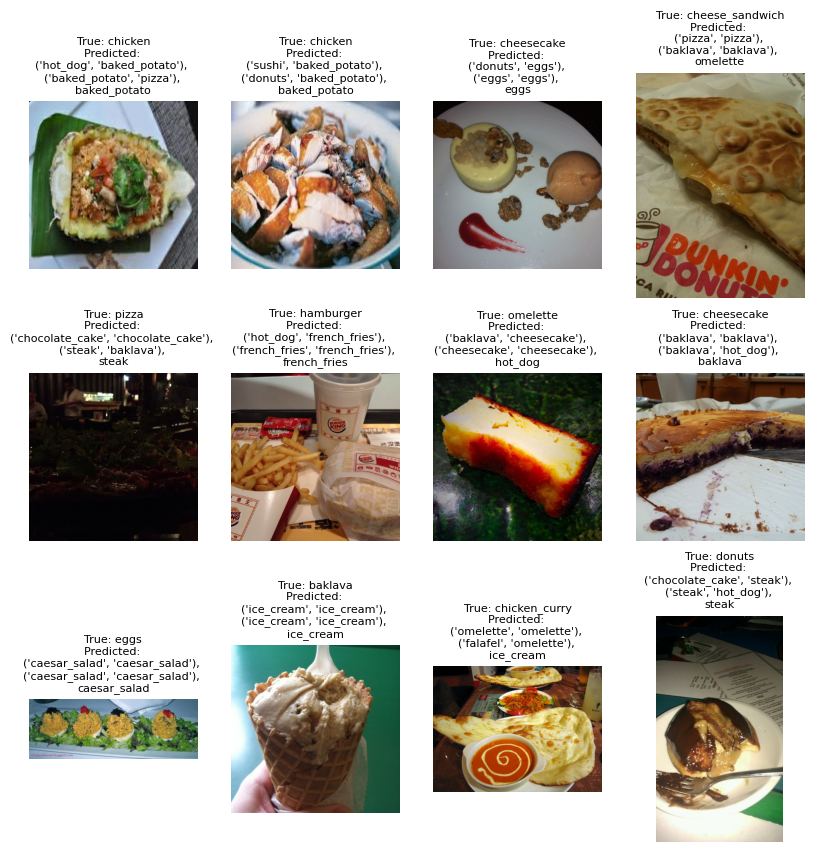

In [79]:
### Showing Some MisClassified Images

selected_idx = np.random.choice(all_classifiers_wrong_predicted_aug, 12)
plot_X = read_img(X_valid.iloc[selected_idx, :])

plot_y = [sorted(categories)[label] for label in y_valid[selected_idx]]
plot_y_predicted_0 = [sorted(categories)[label] for label in np.array(pred_labels[0])[selected_idx]]
plot_y_predicted_1 = [sorted(categories)[label] for label in np.array(pred_labels[1])[selected_idx]]
plot_y_predicted_2 = [sorted(categories)[label] for label in np.array(pred_labels[2])[selected_idx]]

plot_y_predicted_3 = [sorted(categories)[label] for label in np.array(pred_labels[3])[selected_idx]]
plot_y_predicted_4 = [sorted(categories)[label] for label in np.array(pred_labels[4])[selected_idx]]

plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)

    image_rgb = cv2.cvtColor(plot_X['image'][i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

    plt.title(f"True: {plot_y[i]}\nPredicted: \n{plot_y_predicted_0[i], plot_y_predicted_1[i]}, \n{plot_y_predicted_2[i], plot_y_predicted_3[i]}, \n{plot_y_predicted_4[i]}",
              fontsize=8)
    plt.axis('off')
plt.show()

In [80]:
## Loading Saved Best Models

InceptionV3_imagenet, history_InceptionV3_imagenet= Load_Model(saving_path, 'InceptionV3_imagenet')
MobileNet_imagenet, history_MobileNet_imagenet= Load_Model(saving_path, 'MobileNet_imagenet')
Xception_imagenet, history_Xception_imagenet= Load_Model(saving_path, 'Xception_imagenet')
InceptionResNetV2_imagenet, history_InceptionResNetV2_imagenet= Load_Model(saving_path, 'InceptionResNetV2_imagenet')
DenseNet201_imagenet, history_DenseNet201_imagenet= Load_Model(saving_path, 'DenseNet201_imagenet')

In [81]:
models = [InceptionV3_imagenet, MobileNet_imagenet, Xception_imagenet, InceptionResNetV2_imagenet, DenseNet201_imagenet]
true_labels, pred_labels = evaluate_models(models, valid_generator)

1/1 [==============================] - 3s 3s/step


In [82]:
classification_result = pd.DataFrame([np.array(pred_labels[0]) == np.array(true_labels[0]).astype(int),
                       np.array(pred_labels[1]) == np.array(true_labels[1]).astype(int),
                       np.array(pred_labels[2]) == np.array(true_labels[2]).astype(int),
                       np.array(pred_labels[3]) == np.array(true_labels[3]).astype(int),
                       np.array(pred_labels[4]) == np.array(true_labels[4]).astype(int)])
all_classifiers_wrong_predicted = np.where(classification_result.sum() == 0)[0]
all_classifiers_wrong_predicted

array([  11,   25,   29,   64,   78,  109,  124,  145,  146,  195,  226,
        254,  308,  314,  354,  374,  382,  408,  420,  427,  438,  442,
        444,  462,  486,  510,  548,  551,  572,  575,  585,  734,  764,
        781,  806,  859,  954,  961,  994,  995, 1026, 1030, 1051, 1064,
       1066, 1080, 1121, 1129, 1153, 1160, 1185, 1213, 1215, 1268, 1302,
       1331, 1338, 1341, 1360, 1398, 1404, 1421, 1446, 1463, 1483, 1516,
       1523, 1529, 1567, 1578, 1609, 1618, 1620, 1636, 1651, 1654, 1683,
       1687, 1692, 1738, 1753, 1788, 1791, 1801, 1820, 1828, 1869, 1878,
       1909, 1917, 1949, 1960, 2011, 2018, 2067, 2073, 2096, 2118, 2135,
       2167, 2174, 2234, 2248, 2328, 2344, 2359, 2366, 2405, 2429, 2452,
       2472, 2497, 2532, 2551, 2571, 2593, 2608, 2631, 2723, 2727, 2732,
       2737, 2747, 2767, 2770, 2811, 2895, 2986, 2998, 3042, 3049, 3117,
       3122, 3130, 3141, 3148, 3163, 3175, 3177, 3181, 3190, 3205, 3206,
       3233, 3239, 3255, 3291, 3299, 3308, 3309, 33

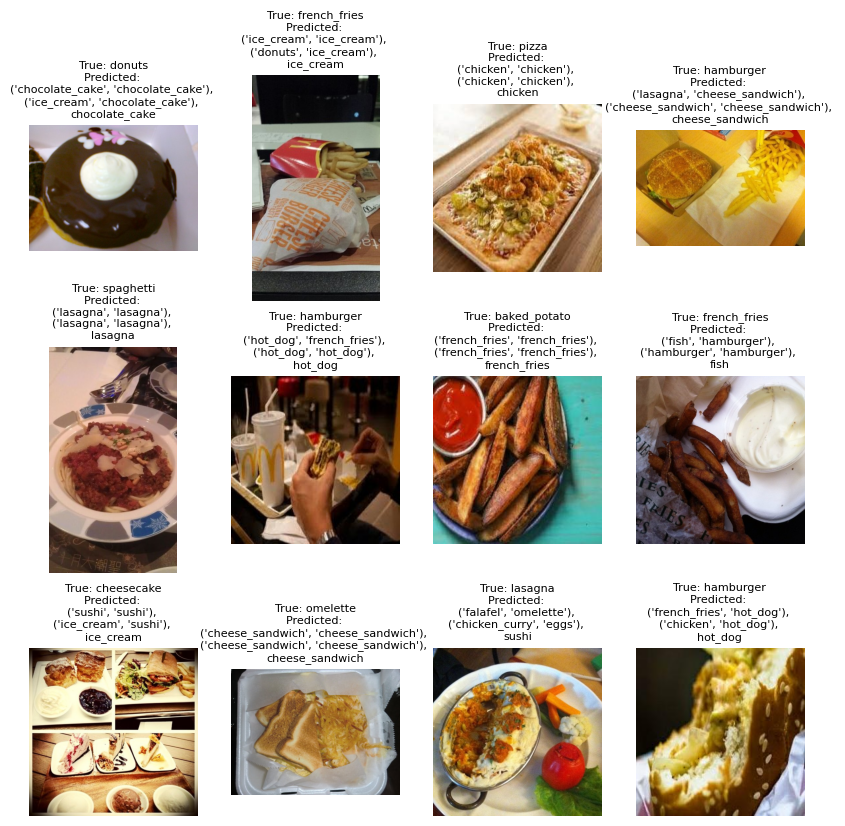

In [83]:
### Showing Some MisClassified Images

selected_idx = np.random.choice(all_classifiers_wrong_predicted, 12)
plot_X = read_img(X_valid.iloc[selected_idx, :])

plot_y = [sorted(categories)[label] for label in y_valid[selected_idx]]
plot_y_predicted_0 = [sorted(categories)[label] for label in np.array(pred_labels[0])[selected_idx]]
plot_y_predicted_1 = [sorted(categories)[label] for label in np.array(pred_labels[1])[selected_idx]]
plot_y_predicted_2 = [sorted(categories)[label] for label in np.array(pred_labels[2])[selected_idx]]

plot_y_predicted_3 = [sorted(categories)[label] for label in np.array(pred_labels[3])[selected_idx]]
plot_y_predicted_4 = [sorted(categories)[label] for label in np.array(pred_labels[4])[selected_idx]]

plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)

    image_rgb = cv2.cvtColor(plot_X['image'][i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

    plt.title(f"True: {plot_y[i]}\nPredicted: \n{plot_y_predicted_0[i], plot_y_predicted_1[i]}, \n{plot_y_predicted_2[i], plot_y_predicted_3[i]}, \n{plot_y_predicted_4[i]}",
              fontsize=8)
    plt.axis('off')
plt.show()

In [84]:
print('Wrong on all Samples:',
      len(all_classifiers_wrong_predicted),
      '\nWrong on all Samples (Aug):', len(all_classifiers_wrong_predicted_aug))

Wrong on all Samples: 158 
Wrong on all Samples (Aug): 141


In [85]:
# True on all classifiers and wrong on inceptionv3
print('Just Wrong on InceptionV3:',
      len(np.where((classification_result.sum() == 4) & (classification_result.iloc[1] == 0))[0]),
      '\nJust Wrong on InceptionV3 (Aug):', len(np.where((classification_result_aug.sum() == 4) & (classification_result_aug.iloc[1] == 0))[0]))

Just Wrong on InceptionV3: 101 
Just Wrong on InceptionV3 (Aug): 73


## Another Augmentation

In [86]:
InceptionV3_imagenet, history_InceptionV3_imagenet= Load_Model(saving_path, 'InceptionV3_imagenet')
MobileNet_imagenet, history_MobileNet_imagenet= Load_Model(saving_path, 'MobileNet_imagenet')
Xception_imagenet, history_Xception_imagenet= Load_Model(saving_path, 'Xception_imagenet')
InceptionResNetV2_imagenet, history_InceptionResNetV2_imagenet= Load_Model(saving_path, 'InceptionResNetV2_imagenet')
DenseNet201_imagenet, history_DenseNet201_imagenet= Load_Model(saving_path, 'DenseNet201_imagenet')

In [87]:
## Random Undersampling

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

## Number of samples in each categories
from collections import Counter
print(Counter(y_res))

Counter({0: 456, 1: 456, 2: 456, 3: 456, 4: 456, 5: 456, 6: 456, 7: 456, 8: 456, 9: 456, 10: 456, 11: 456, 12: 456, 13: 456, 14: 456, 15: 456, 16: 456, 17: 456, 18: 456, 19: 456, 20: 456, 21: 456})


In [88]:
df_train = pd.DataFrame({'image_path': X_res.dest.tolist(), 'label': y_res.tolist()})

train_generator = DataGenerator(dataframe=df_train, batch_size=512, target_size=target_size)

models = [InceptionV3_imagenet, Xception_imagenet, DenseNet201_imagenet,
              InceptionResNetV2_imagenet, MobileNet_imagenet]

true_labels_train, pred_labels_train = evaluate_models(models, train_generator)

10/10 [==============================] - 0s 13ms/step


In [89]:
classification_result = pd.DataFrame([np.array(pred_labels_train[0]) == np.array(true_labels_train[0]).astype(int),
                       np.array(pred_labels_train[1]) == np.array(true_labels_train[1]).astype(int),
                       np.array(pred_labels_train[2]) == np.array(true_labels_train[2]).astype(int),
                       np.array(pred_labels_train[3]) == np.array(true_labels_train[3]).astype(int),
                       np.array(pred_labels_train[4]) == np.array(true_labels_train[4]).astype(int)])
classifiers_all_right_predicted = np.where(classification_result.sum() > 4)[0]
classifiers_all_right_predicted

array([    0,     1,     2, ..., 10028, 10029, 10030])

In [90]:
X_selected_aug = X_res.iloc[classifiers_all_right_predicted]
y_selected_aug = y_res[classifiers_all_right_predicted]

In [91]:
# label_in_array = np.eye(len(categories))
min_class_index = np.argmin(list(Counter(y_train).values()))
min_size = min(list(Counter(y_train).values()))
max_size = max(list(Counter(y_train).values()))

sampling_strategy = 0.5

ratio = {class_label: sampling_strategy*max_size/Counter(y_train)[class_label] for class_label in range(len(categories))}

for num in np.where(np.array(list(Counter(y_train).values())) * sampling_strategy < min_size)[0]:
    ratio[list(Counter(y_train).keys())[num]] = 1

target_balance_ratios = {class_label: int(max(Counter(y_train)[class_label]*ratio[class_label], min_size))  for class_label in range(len(categories))}

rus = RandomUnderSampler(random_state=42, sampling_strategy=target_balance_ratios)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Print the distribution of classes after undersampling
print("Distribution of classes after undersampling:")
print(Counter(y_res))

Distribution of classes after undersampling:
Counter({0: 833, 5: 833, 8: 833, 12: 833, 13: 833, 19: 833, 14: 743, 18: 603, 6: 523, 17: 514, 10: 511, 9: 506, 1: 498, 16: 493, 11: 488, 20: 488, 3: 486, 7: 486, 2: 479, 15: 477, 21: 460, 4: 456})


In [92]:
aug_path = aug_saving_path + "augmented_mod_images"

In [93]:
max_samples = max(list(Counter(y_res).values()))
augmented_images, augmented_labels = augment_data(X_selected_aug, y_selected_aug, max_samples)

for label in categories:
    os.makedirs(os.path.join(aug_path, str(label)), exist_ok=True)

for image, label in zip(augmented_images, augmented_labels):
    label = categories[encoded_categories.index(label)]

    directory = os.path.join(aug_path, str(label))
    filename = f"image_{len(os.listdir(directory))}.png"
    cv2.imwrite(os.path.join(directory, filename), image)

In [94]:
data = []

for folders, _, files in os.walk(aug_path):
    for file in files:
        folder_name = folders.split('/')[-1]
        dest = f'{folders}/{file}'
        data.append({'name': file, 'label': folder_name, 'dest': dest})

df_aug = pd.DataFrame(data)

y_aug = df_aug['label']
y_aug = label_encoder.transform(y_aug)

X_aug = df_aug.drop(columns = ['label'])

print(Counter(y_aug))

Counter({17: 522, 18: 463, 6: 458, 16: 457, 4: 448, 10: 443, 7: 442, 21: 441, 3: 440, 1: 438, 13: 438, 20: 432, 14: 428, 9: 427, 12: 427, 2: 422, 5: 419, 11: 419, 19: 414, 15: 413, 0: 408, 8: 407})


In [95]:
X_aug = pd.concat([X_aug, X_res])
y_aug = np.append(y_aug, y_res)

print(Counter(y_aug))

Counter({13: 1271, 12: 1260, 5: 1252, 19: 1247, 0: 1241, 8: 1240, 14: 1171, 18: 1066, 17: 1036, 6: 981, 10: 954, 16: 950, 1: 936, 9: 933, 7: 928, 3: 926, 20: 920, 11: 907, 4: 904, 2: 901, 21: 901, 15: 890})


In [96]:
rus = RandomUnderSampler(random_state=42)
X_aug, y_aug = rus.fit_resample(X_aug, y_aug)

## Number of samples in each categories
from collections import Counter
print(Counter(y_aug))

Counter({0: 890, 1: 890, 2: 890, 3: 890, 4: 890, 5: 890, 6: 890, 7: 890, 8: 890, 9: 890, 10: 890, 11: 890, 12: 890, 13: 890, 14: 890, 15: 890, 16: 890, 17: 890, 18: 890, 19: 890, 20: 890, 21: 890})


## Continue On Selected Models

In [97]:
df_aug_train = pd.DataFrame({'image_path': X_aug.dest.tolist(), 'label': y_aug.tolist()})
df_valid = pd.DataFrame({'image_path': X_valid.dest.tolist(), 'label': y_valid.tolist()})

train_generator = DataGenerator(dataframe=df_aug_train, batch_size=batch_size, target_size=target_size)
valid_generator = DataGenerator(dataframe=df_valid, batch_size=batch_size, target_size=target_size)

### Models

In [98]:
## InceptionV3

model = InceptionV3(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionV3_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_InceptionV3_imagenet, model, 'InceptionV3_augmented_mod_imagenet')

Epoch 1/30


/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


612/612 [==============================] - 162s 215ms/step - loss: 2.7505 - accuracy: 0.2309 - val_loss: 27.3388 - val_accuracy: 0.0354
Epoch 2/30
612/612 [==============================] - 125s 205ms/step - loss: 2.9357 - accuracy: 0.1076 - val_loss: 2.5065 - val_accuracy: 0.3402
Epoch 3/30
612/612 [==============================] - 130s 212ms/step - loss: 0.8364 - accuracy: 0.7604 - val_loss: 0.6971 - val_accuracy: 0.8035
Epoch 4/30
612/612 [==============================] - 125s 205ms/step - loss: 0.2524 - accuracy: 0.9261 - val_loss: 0.7033 - val_accuracy: 0.8101
Epoch 5/30
612/612 [==============================] - 131s 215ms/step - loss: 0.1183 - accuracy: 0.9654 - val_loss: 0.6716 - val_accuracy: 0.8303
Epoch 6/30
612/612 [==============================] - 131s 214ms/step - loss: 0.0777 - accuracy: 0.9754 - val_loss: 0.7478 - val_accuracy: 0.8206
Epoch 7/30
612/612 [==============================] - 131s 214ms/step - loss: 0.0636 - accuracy: 0.9800 - val_loss: 0.7545 - val_accur

In [99]:
## Xception

model = Xception(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_Xception_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_Xception_imagenet, model, 'Xception_augmented_mod_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
612/612 [==============================] - 149s 211ms/step - loss: 0.7937 - accuracy: 0.7962 - val_loss: 0.4960 - val_accuracy: 0.8616
Epoch 2/30
612/612 [==============================] - 129s 211ms/step - loss: 0.1341 - accuracy: 0.9657 - val_loss: 0.4681 - val_accuracy: 0.8721
Epoch 3/30
612/612 [==============================] - 124s 203ms/step - loss: 0.0397 - accuracy: 0.9911 - val_loss: 0.4850 - val_accuracy: 0.8766
Epoch 4/30
612/612 [==============================] - 127s 207ms/step - loss: 0.0195 - accuracy: 0.9962 - val_loss: 0.5313 - val_accuracy: 0.8705
Epoch 5/30
612/612 [==============================] - 129s 210ms/step - loss: 0.0228 - accuracy: 0.9947 - val_loss: 0.6009 - val_accuracy: 0.8594
Epoch 6/30
612/612 [==============================] - 129s 210ms/step - loss: 0.0273 - accuracy: 0.9919 - val_loss: 0.6323 - val_accuracy: 0.8577


In [100]:
## DenseNet201

model = DenseNet201(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet201_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_DenseNet201_imagenet, model, 'DenseNet201_augmented_mod_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
612/612 [==============================] - 228s 234ms/step - loss: 0.5670 - accuracy: 0.8437 - val_loss: 0.4619 - val_accuracy: 0.8677
Epoch 2/30
612/612 [==============================] - 134s 218ms/step - loss: 0.1084 - accuracy: 0.9710 - val_loss: 0.4235 - val_accuracy: 0.8821
Epoch 3/30
612/612 [==============================] - 133s 218ms/step - loss: 0.0454 - accuracy: 0.9893 - val_loss: 0.4744 - val_accuracy: 0.8785
Epoch 4/30
612/612 [==============================] - 131s 213ms/step - loss: 0.0487 - accuracy: 0.9871 - val_loss: 0.5213 - val_accuracy: 0.8630
Epoch 5/30
612/612 [==============================] - 132s 216ms/step - loss: 0.0527 - accuracy: 0.9849 - val_loss: 0.5078 - val_accuracy: 0.8699
Epoch 6/30
612/612 [==============================] - 135s 221ms/step - loss: 0.0443 - accuracy: 0.9872 - val_loss: 0.6020 - val_accuracy: 0.8619


In [101]:
## InceptionResNetV2

model = InceptionResNetV2(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionResNetV2_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_InceptionResNetV2_imagenet, model, 'InceptionResNetV2_augmented_mod_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
612/612 [==============================] - 209s 226ms/step - loss: 0.6441 - accuracy: 0.8194 - val_loss: 0.5548 - val_accuracy: 0.8439
Epoch 2/30
612/612 [==============================] - 131s 214ms/step - loss: 0.1339 - accuracy: 0.9636 - val_loss: 0.8266 - val_accuracy: 0.8439
Epoch 3/30
612/612 [==============================] - 131s 215ms/step - loss: 0.0667 - accuracy: 0.9790 - val_loss: 0.5854 - val_accuracy: 0.8478
Epoch 4/30
612/612 [==============================] - 134s 218ms/step - loss: 0.0457 - accuracy: 0.9863 - val_loss: 0.6901 - val_accuracy: 0.8433
Epoch 5/30
612/612 [==============================] - 132s 215ms/step - loss: 0.0472 - accuracy: 0.9860 - val_loss: 0.7393 - val_accuracy: 0.8337
Epoch 6/30
612/612 [==============================] - 133s 216ms/step - loss: 0.0416 - accuracy: 0.9875 - val_loss: 0.7170 - val_accuracy: 0.8550


In [102]:
## MobileNet

model = MobileNet(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_MobileNet_imagenet = compiling_block(model, train_generator)
Saving_Model_Output(saving_path, history_MobileNet_imagenet, model, 'MobileNet_augmented_mod_imagenet')

/tmp/ipykernel_289/3608707205.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
612/612 [==============================] - 141s 213ms/step - loss: 0.8645 - accuracy: 0.7540 - val_loss: 0.5991 - val_accuracy: 0.8248
Epoch 2/30
612/612 [==============================] - 125s 205ms/step - loss: 0.2264 - accuracy: 0.9436 - val_loss: 0.5489 - val_accuracy: 0.8411
Epoch 3/30
612/612 [==============================] - 122s 199ms/step - loss: 0.0852 - accuracy: 0.9840 - val_loss: 0.5308 - val_accuracy: 0.8467
Epoch 4/30
612/612 [==============================] - 125s 205ms/step - loss: 0.0351 - accuracy: 0.9964 - val_loss: 0.5152 - val_accuracy: 0.8616
Epoch 5/30
612/612 [==============================] - 123s 201ms/step - loss: 0.0184 - accuracy: 0.9988 - val_loss: 0.5413 - val_accuracy: 0.8597
Epoch 6/30
612/612 [==============================] - 128s 209ms/step - loss: 0.0143 - accuracy: 0.9985 - val_loss: 0.5689 - val_accuracy: 0.8530


### Evaluation

In [104]:
InceptionV3_augmented_imagenet, history_InceptionV3_augmented_imagenet= Load_Model(saving_path, 'InceptionV3_augmented_mod_imagenet')
Xception_augmented_imagenet, history_Xception_augmented_imagenet= Load_Model(saving_path, 'Xception_augmented_mod_imagenet')
DenseNet201_augmented_imagenet, history_DenseNet201_augmented_imagenet= Load_Model(saving_path, 'DenseNet201_augmented_mox_imagenet')
InceptionResNetV2_augmented_imagenet, history_InceptionResNetV2_augmented_imagenet= Load_Model(saving_path, 'InceptionResNetV2_augmented_mod_imagenet')
MobileNet_augmented_imagenet, history_MobileNet_augmented_imagenet= Load_Model(saving_path, 'MobileNet_augmented_mod_imagenet')

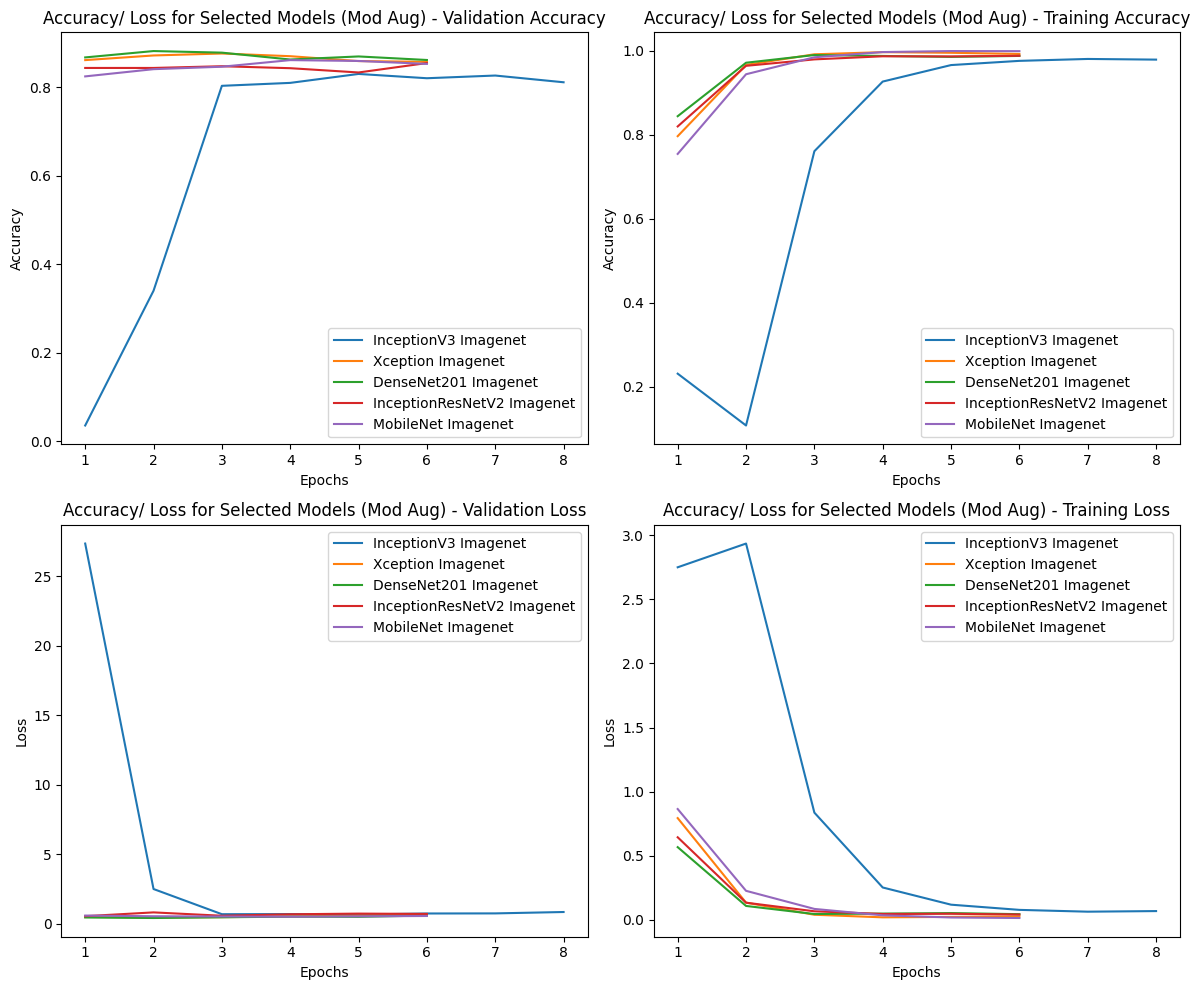

In [105]:
models_hist = [history_InceptionV3_augmented_imagenet, history_Xception_augmented_imagenet, history_DenseNet201_augmented_imagenet,
              history_InceptionResNetV2_augmented_imagenet, history_MobileNet_augmented_imagenet]

models_name = ['InceptionV3 Imagenet', 'Xception Imagenet', 'DenseNet201 Imagenet',
              'InceptionResNetV2 Imagenet', 'MobileNet Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy/ Loss for Selected Models (Mod Aug)')

In [106]:
valid_generator = DataGenerator(dataframe=df_valid, batch_size=512, target_size=target_size)

models = [InceptionV3_augmented_imagenet, Xception_augmented_imagenet, DenseNet201_augmented_imagenet,
         InceptionResNetV2_augmented_imagenet, MobileNet_augmented_imagenet]
models_name = ['InceptionV3 Imagenet', 'Xception Imagenet', 'DenseNet201 Imagenet',
              'InceptionResNetV2 Imagenet', 'MobileNet Imagenet']

true_labels_mod_aug, pred_labels_mod_aug = evaluate_models(models, valid_generator)

1/1 [==============================] - 0s 331ms/step


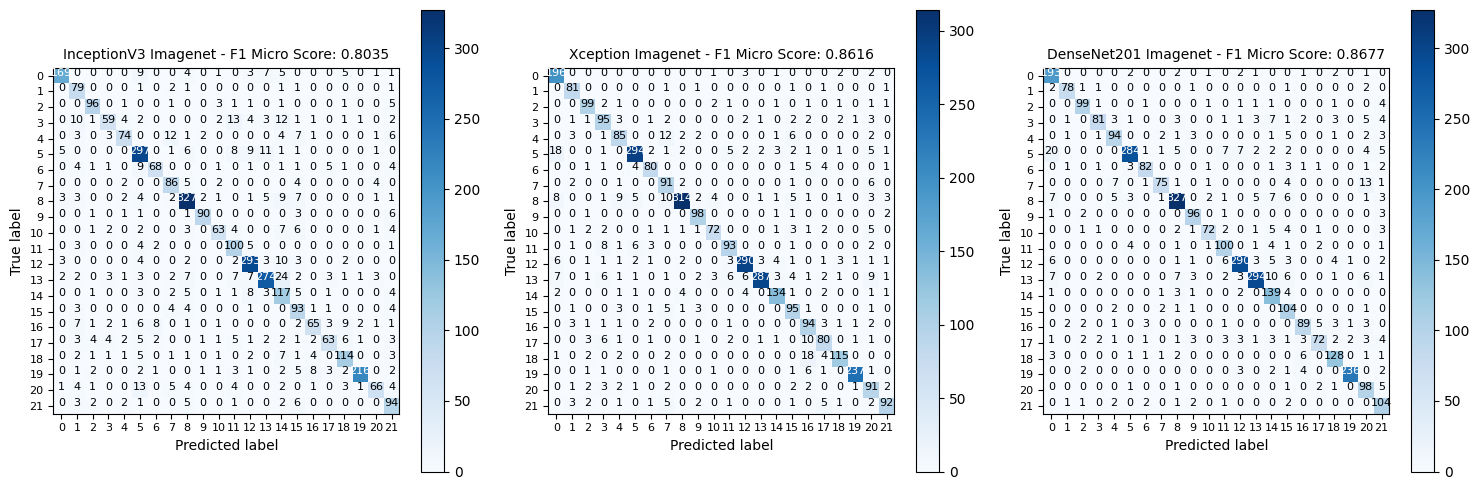

In [107]:
plot_confusion_matrix(true_labels_mod_aug[:3], pred_labels_mod_aug[:3], models_name[:3])

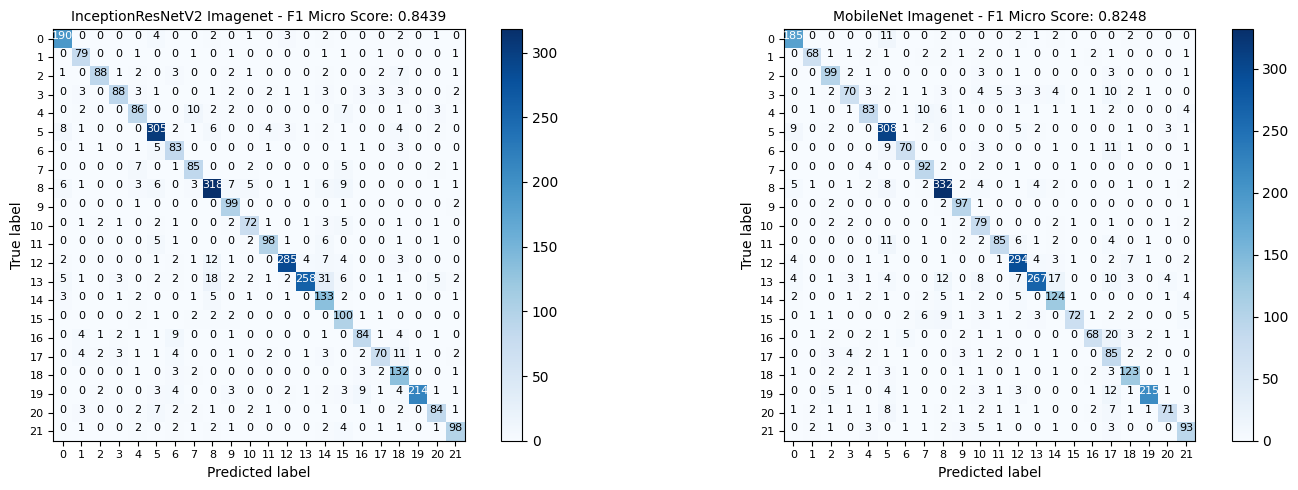

In [108]:
plot_confusion_matrix(true_labels_mod_aug[3:], pred_labels_mod_aug[3:], models_name[3:])

## Evaluation on My Test

In [163]:
selected_models = [Xception_augmented_imagenet, DenseNet201_augmented_imagenet, DenseNet201_imagenet]
selected_models_name = ['Xception Augmented Imagenet',
                        'DenseNet201 Augmented Imagenet', 'DenseNet201 Imagenet', 'Majority']

In [164]:
df_test = pd.DataFrame({'image_path': X_test.dest.tolist(), 'label': y_test.tolist()})
test_generator = DataGenerator(dataframe=df_test, batch_size=512, target_size=target_size)

In [165]:
true_labels_test, pred_labels_test = evaluate_models(selected_models, test_generator)

1/1 [==============================] - 0s 41ms/step


In [166]:
from scipy.stats import mode

result = mode(pred_labels_test, axis=0)

majority_votes = result.mode

print("Majority votes for each position:", majority_votes.flatten())

Majority votes for each position: [ 8 19 10 ...  3 10  9]


/tmp/ipykernel_289/1159076036.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  result = mode(pred_labels_test, axis=0)


In [167]:
pred_labels_test.append(list(majority_votes.flatten()))
true_labels_test.append(list(true_labels_test[0]))

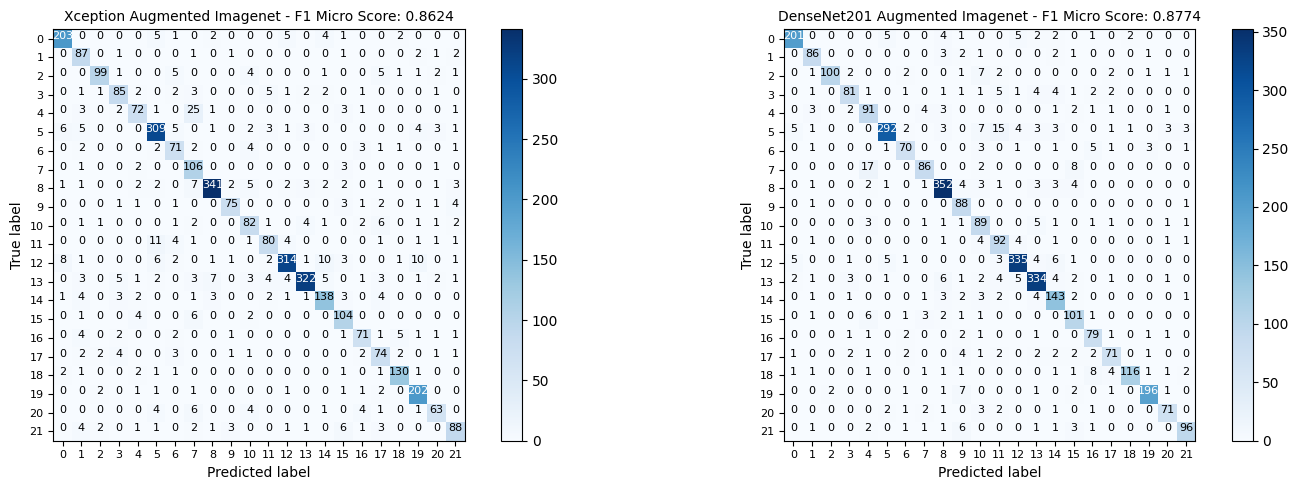

In [168]:
plot_confusion_matrix(true_labels_test[:2], pred_labels_test[:2], selected_models_name[:2])

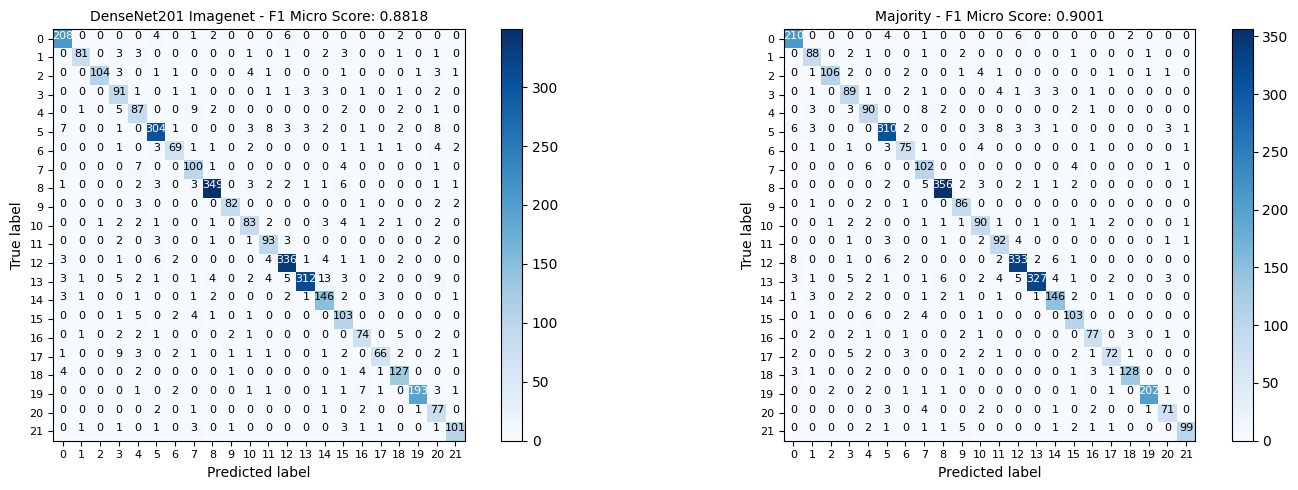

In [169]:
plot_confusion_matrix(true_labels_test[2:], pred_labels_test[2:], selected_models_name[2:])

In [170]:
y_predicted = [sorted(categories)[label] for label in np.array(majority_votes.flatten())]
final = pd.concat([X_test.name.reset_index(drop=True), pd.Series(y_predicted)], axis = 1)
final.columns = ['name', 'predicted']
final.to_csv('q1_submission.csv', index = False)

In [171]:
final

name        predicted
0     04340043-2c9.jpg           donuts
1     f4661691-e00.jpg        spaghetti
2     f63707b6-e35.jpg          falafel
3     8b8074dc-094.jpg   chocolate_cake
4     85859f41-361.jpg          chicken
...                ...              ...
3608  cf177bb8-8d6.jpg           donuts
3609  416d5fb1-9ec.jpg        ice_cream
3610  4a16defe-60f.jpg  cheese_sandwich
3611  6096b40b-685.jpg          falafel
3612  cd72cc50-c9f.jpg             eggs

[3613 rows x 2 columns]